# New Zealand Time-series Forecasting Model

# Pre-processing and Modeling 

In this notebook we are going to do pre-processing and modeling on our time-series data. We are going to decide what we want to focus on with this modeling. 

We'll start with the tourism arrivals data and then look at the accomodation data. 

We will beging by importing the necessary packages for looking at the data and creating our models.

[1.0 Tourism Data](#1.0-Tourism-Data)

[2.0 Accomodation Data](#2.0-Accomodation-Data)

In [138]:
# Import data processing packages
import pandas as pd
import numpy as np
from datetime import timedelta
from sklearn.metrics import mean_squared_error

#Time Series and Metrics Packages
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error


#Time Series Modeling Packages
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from pmdarima import auto_arima
from statsmodels.tsa.statespace import sarimax 
from statsmodels.tsa.exponential_smoothing.ets import ETSModel
from darts.models.forecasting import tbats
from darts import TimeSeries
from sklearn.ensemble import RandomForestRegressor

#Modeling packages
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
import datetime as dt

#Visualization 
import matplotlib. pyplot as plt
import seaborn as sns

In [2]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 
warnings.filterwarnings("ignore", 'No frequency') 

# 1.0 Tourism Data
For our `arrivals` data we are going to look at the following regions as these have the most complete time-series data:
> - Auckland
> - Christchurch
> - Wellington
> - Queenstown
> - All New Zealand Ports
    
For each of these regions, we are going to look at the following reasons for travel:
> - Business
> - Holiday
> - Visiting Friends
> - Total Travel

We want to create the most complete picture that we can for our forecasting and making sure we work on creating as thorough of a forecasting as we can. 

In [3]:
## Load our Tourism Data
# Remove extra white space at end of column

arrivals = pd.read_csv('../NZ Data/Arrivals Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
arrivals.columns = arrivals.columns.str.replace(r' $','', regex = True)
arrivals.columns

Index(['BusinessAuckland', 'BusinessChristchurch', 'BusinessDunedin',
       'BusinessHamilton', 'BusinessPalmerston North', 'BusinessRotorua',
       'BusinessWellington', 'BusinessQueenstown',
       'BusinessTOTAL NEW ZEALAND PORTS', 'Holiday/VacationAuckland',
       'Holiday/VacationChristchurch', 'Holiday/VacationDunedin',
       'Holiday/VacationHamilton', 'Holiday/VacationPalmerston North',
       'Holiday/VacationRotorua', 'Holiday/VacationWellington',
       'Holiday/VacationQueenstown', 'Holiday/VacationTOTAL NEW ZEALAND PORTS',
       'Visit Friends/RelativesAuckland',
       'Visit Friends/RelativesChristchurch', 'Visit Friends/RelativesDunedin',
       'Visit Friends/RelativesHamilton',
       'Visit Friends/RelativesPalmerston North',
       'Visit Friends/RelativesRotorua', 'Visit Friends/RelativesWellington',
       'Visit Friends/RelativesQueenstown',
       'Visit Friends/RelativesTOTAL NEW ZEALAND PORTS',
       'TOTAL ALL TRAVEL PURPOSESAuckland',
       'TOTAL ALL

In [4]:
# Check to make sure index is datetime
arrivals.index

DatetimeIndex(['1978-04-01', '1978-05-01', '1978-06-01', '1978-07-01',
               '1978-08-01', '1978-09-01', '1978-10-01', '1978-11-01',
               '1978-12-01', '1979-01-01',
               ...
               '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01',
               '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01',
               '2022-04-01', '2022-05-01'],
              dtype='datetime64[ns]', name='Date', length=530, freq=None)

In [5]:
arrivals.head()

BusinessAuckland  BusinessChristchurch  BusinessDunedin  \
Date                                                                  
1978-04-01            3428.0                 468.0              0.0   
1978-05-01            2264.0                 524.0              0.0   
1978-06-01            2136.0                 280.0              0.0   
1978-07-01            2156.0                 324.0              0.0   
1978-08-01            2304.0                 536.0              0.0   

            BusinessHamilton  BusinessPalmerston North  BusinessRotorua  \
Date                                                                      
1978-04-01               0.0                       0.0              0.0   
1978-05-01               0.0                       0.0              0.0   
1978-06-01               0.0                       0.0              0.0   
1978-07-01               0.0                       0.0              0.0   
1978-08-01               0.0                       0.0              0.0   

            BusinessWellington  BusinessQueenstown  \
Date                                                 
1978-04-01               492.0                 0.0   
1978-05-01               428.0                 0.0   
1978-06-01               384.0                 0.0   
1978-07-01               380.0                 0.0   
1978-08-01               496.0                 0.0   

            BusinessTOTAL NEW ZEALAND PORTS  Holiday/VacationAuckland  ...  \
Date                                                                   ...   
1978-04-01                           4408.0                   10476.0  ...   
1978-05-01                           3236.0                    7168.0  ...   
1978-06-01                           2880.0                    4640.0  ...   
1978-07-01                           2964.0                    6184.0  ...   
1978-08-01                           3416.0                    8236.0  ...   

            Visit Friends/RelativesTOTAL NEW ZEALAND PORTS  \
Date                                                         
1978-04-01                                          3324.0   
1978-05-01                                          3568.0   
1978-06-01                                          2600.0   
1978-07-01                                          3144.0   
1978-08-01                                          4204.0   

            TOTAL ALL TRAVEL PURPOSESAuckland  \
Date                                            
1978-04-01                            19856.0   
1978-05-01                            15428.0   
1978-06-01                            11416.0   
1978-07-01                            14072.0   
1978-08-01                            17960.0   

            TOTAL ALL TRAVEL PURPOSESChristchurch  \
Date                                                
1978-04-01                                 6240.0   
1978-05-01                                 5240.0   
1978-06-01                                 2708.0   
1978-07-01                                 4900.0   
1978-08-01                                 7900.0   

            TOTAL ALL TRAVEL PURPOSESDunedin  \
Date                                           
1978-04-01                               0.0   
1978-05-01                               0.0   
1978-06-01                               0.0   
1978-07-01                               0.0   
1978-08-01                               0.0   

            TOTAL ALL TRAVEL PURPOSESHamilton  \
Date                                            
1978-04-01                                0.0   
1978-05-01                                0.0   
1978-06-01                                0.0   
1978-07-01                                0.0   
1978-08-01                                0.0   

            TOTAL ALL TRAVEL PURPOSESPalmerston North  \
Date                                                    
1978-04-01                                        0.0   
1978-05-01                                        0.0   
19

In [6]:
# Load our model results from the pycaret notebook to look at which models might work best for us
potential_models = pd.read_csv('../NZ Data/arrivals_model_results.csv',index_col = 0)
potential_models.head()

Model        MAE  \
exp_smooth                         Exponential Smoothing  1847.5938   
lr_cds_dt     Linear w/ Cond. Deseasonalize & Detrending   292.8787   
huber_cds_dt   Huber w/ Cond. Deseasonalize & Detrending    23.9385   
naive                                   Naive Forecaster     0.5139   
naive                                   Naive Forecaster     0.0000   

                   RMSE          MAPE   SMAPE    MASE   RMSSE      R2  \
exp_smooth    3040.2741  8.729000e+00  0.1226  2.1202  2.6894  0.5610   
lr_cds_dt      448.0243  1.619677e+17  0.1555  1.2487  1.4706  0.4044   
huber_cds_dt    29.7550  2.358377e+16  0.5721  1.2396  0.8072 -0.4410   
naive            2.4227  5.560000e-02  0.1111  0.0278  0.0721 -0.0580   
naive            0.0000  0.000000e+00  0.0000  0.0000  0.0000  1.0000   

              TT (Sec)               time_series  
exp_smooth      0.0433          BusinessAuckland  
lr_cds_dt       0.0133      BusinessChristchurch  
huber_cds_dt    0.0300           BusinessDunedin  
naive           0.0067          BusinessHamilton  
naive           0.0033  BusinessPalmerston North

We have here the list of all of our models that we tested using the pycaret model. As discussed in our previous notebook, we are not interested in actually modeling out all of these trends due to issues with the data or lack of historic data. We'll start with looking at our Arrivals dataset.

We will be forecasting the following datasets from the Arrivals dataset:
- TOTAL ALL TRAVEL PURPOSESAuckland
- TOTAL ALL TRAVEL PURPOSESChristchurch
- TOTAL ALL TRAVEL PURPOSESWellington
- TOTAL ALL TRAVEL PURPOSESQueenstown
- TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
- BusinessAuckland
- BusinessChristchurch
- BusinessWellington
- BusinessQueenstown
- BusinessTOTAL NEW ZEALAND PORTS
- Holiday/VacationAuckland
- Holiday/VacationChristchurch
- Holiday/VacationWellington
- Holiday/VacationQueenstown
- Holiday/VacationTOTAL NEW ZEALAND PORTS

This is capture a wide breadth of models without overwhelming ourselves. Thus to make our above model results table more readable, we will subset and look at only the subset we are interested in.

In [7]:
# Creating list of subset
arrivals_model_list = ['TOTAL ALL TRAVEL PURPOSESAuckland', 'TOTAL ALL TRAVEL PURPOSESChristchurch', \
                       'TOTAL ALL TRAVEL PURPOSESWellington', 'TOTAL ALL TRAVEL PURPOSESQueenstown',\
                      'TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS',\
                      'BusinessAuckland','BusinessChristchurch','BusinessWellington', 'BusinessQueenstown',\
                      'BusinessTOTAL NEW ZEALAND PORTS',\
                      'Holiday/VacationAuckland','Holiday/VacationChristchurch', 'Holiday/VacationWellington',\
                      'Holiday/VacationQueenstown','Holiday/VacationTOTAL NEW ZEALAND PORTS']

In [8]:
arrivals_model_sub = potential_models[potential_models['time_series'].isin(arrivals_model_list)]
arrivals_model_sub

Model         MAE  \
exp_smooth                       Exponential Smoothing   1847.5938   
lr_cds_dt   Linear w/ Cond. Deseasonalize & Detrending    292.8787   
exp_smooth                       Exponential Smoothing    327.0615   
ets                                                ETS    119.2602   
exp_smooth                       Exponential Smoothing   2358.3273   
exp_smooth                       Exponential Smoothing  12117.3473   
arima                                            ARIMA   3625.2503   
ets                                                ETS    675.4676   
ets                                                ETS   1807.8334   
bats                                              BATS  17376.7744   
ets                                                ETS  19224.7633   
arima                                            ARIMA   4893.7046   
ets                                                ETS   1662.2344   
auto_arima                                  Auto ARIMA   2326.2816   
exp_smooth                       Exponential Smoothing  25144.9588   

                  RMSE          MAPE   SMAPE    MASE   RMSSE      R2  \
exp_smooth   3040.2741  8.729000e+00  0.1226  2.1202  2.6894  0.5610   
lr_cds_dt     448.0243  1.619677e+17  0.1555  1.2487  1.4706  0.4044   
exp_smooth    524.7345  1.770958e+17  0.1482  1.4467  1.7891  0.4479   
ets           168.2450  8.942974e+16  0.2367  3.7151  2.4567  0.2016   
exp_smooth   3905.6734  9.939400e+00  0.1205  2.1454  2.6784  0.5673   
exp_smooth  19304.4273  5.368140e+02  0.1544  2.8171  3.0665  0.7523   
arima        5694.6243  1.042121e+18  0.1666  1.7507  1.9920  0.7231   
ets           984.8151  4.986480e+17  0.1872  1.7478  1.4984  0.6799   
ets          2922.2105  2.023709e+18  0.1426  4.3983  3.0722  0.8024   
bats        27582.7610  5.915086e+02  0.1480  2.8512  3.1626  0.7463   
ets         33545.2596  3.179100e+00  0.1191  2.8423  3.5160  0.7589   
arima        7911.5408  1.922843e+18  0.1445  1.8631  2.1870  0.7533   
ets          2839.0351  1.125903e+18  0.1239  2.0231  2.3315  0.6932   
auto_arima   3805.7324  2.576102e+18  0.1396  4.5332  3.2727  0.7387   
exp_smooth  45003.2397  4.148900e+00  0.1132  2.6886  3.4357  0.7664   

            TT (Sec)                                       time_series  
exp_smooth    0.0433                                  BusinessAuckland  
lr_cds_dt     0.0133                              BusinessChristchurch  
exp_smooth    0.0367                                BusinessWellington  
ets           0.0233                                BusinessQueenstown  
exp_smooth    0.0367                   BusinessTOTAL NEW ZEALAND PORTS  
exp_smooth    0.0400                          Holiday/VacationAuckland  
arima         0.0267                      Holiday/VacationChristchurch  
ets           0.0300                        Holiday/VacationWellington  
ets           0.0300                        Holiday/VacationQueenstown  
bats          7.4733           Holiday/VacationTOTAL NEW ZEALAND PORTS  
ets           0.0667                 TOTAL ALL TRAVEL PURPOSESAuckland  
arima         0.0300             TOTAL ALL TRAVEL PURPOSESChristchurch  
ets           0.0267               TOTAL ALL TRAVEL PURPOSESWellington  
auto_arima   59.5467               TOTAL ALL TRAVEL PURPOSESQueenstown  
exp_smooth    0.0433  TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS

## Modeling Business Time Series

In this section we will model out our business model time series and analyze those results

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

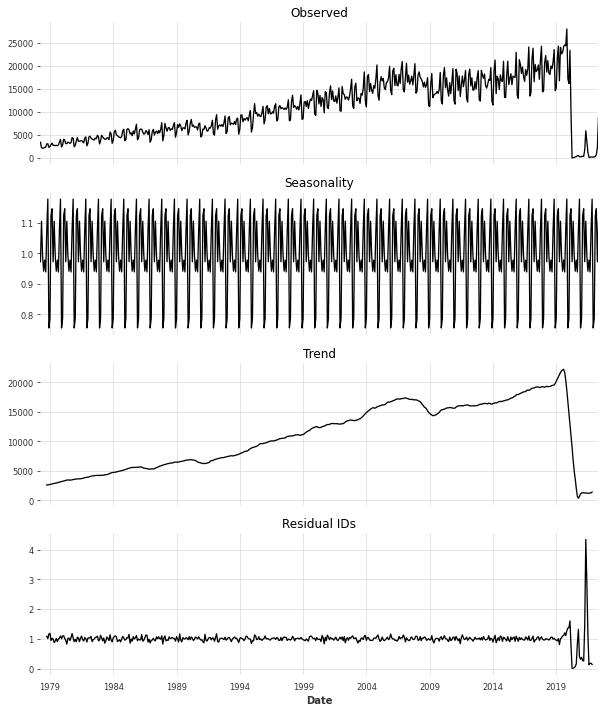

In [9]:
# Start with BusinessAuckland, we will use ExponentialSmoothing to model 
# First lets look at the data and understand its seasonality and ACF/PACF

y = arrivals['BusinessAuckland']

res = seasonal_decompose(y, model='mult')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [10]:
# Since we have opted to use exponential smoothing, we are not required to take the first difference
# Exponential smoothing can handle trend data 
# The statsmodel implementation of Exponentail Smoothing also optimizes its hyperparamters

exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)

In [11]:
exp_fit = exp.fit(method = 'bh')
exp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:         BusinessAuckland   No. Observations:                  530
Model:             ExponentialSmoothing   SSE                      856887329.913
Optimized:                         True   AIC                           7610.848
Trend:                   Multiplicative   BIC                           7683.487
Seasonal:                Multiplicative   AICC                          7612.338
Seasonal Periods:                    12   Date:                 Thu, 28 Jul 2022
Box-Cox:                          False   Time:                         22:11:14
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8037141                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal            0.0890258                gamma                 True
initial_level                 2556.5299                  l.0                 True
initial_trend                 0.8026130                  b.0                 True
damping_trend                 0.8000000                  phi                 True
initial_seasons.0             1.6419320                  s.0                 True
initial_seasons.1             1.6708359                  s.1                 True
initial_seasons.2             1.4780912                  s.2                 True
initial_seasons.3             1.5650568                  s.3                 True
initial_seasons.4             1.6135477                  s.4                 True
initial_seasons.5             1.3943988                  s.5                 True
initial_seasons.6             1.7557214                  s.6                 True
initial_seasons.7             2.0257502                  s.7                 True
initial_seasons.8             1.0635796                  s.8                 True
initial_seasons.9             1.1078800                  s.9                 True
initial_seasons.10            1.7303241                 s.10                 True
initial_seasons.11            1.8023380                 s.11                 True
---------------------------------------------------------------------------------
"""

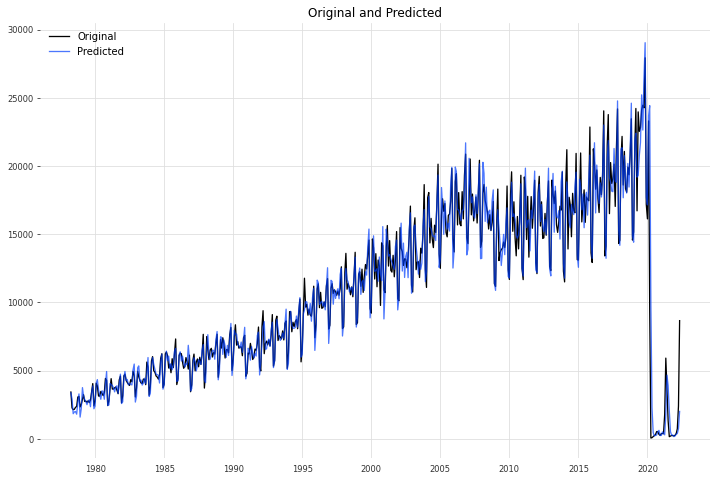

In [12]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [13]:
y_fore = exp_fit.forecast(36)

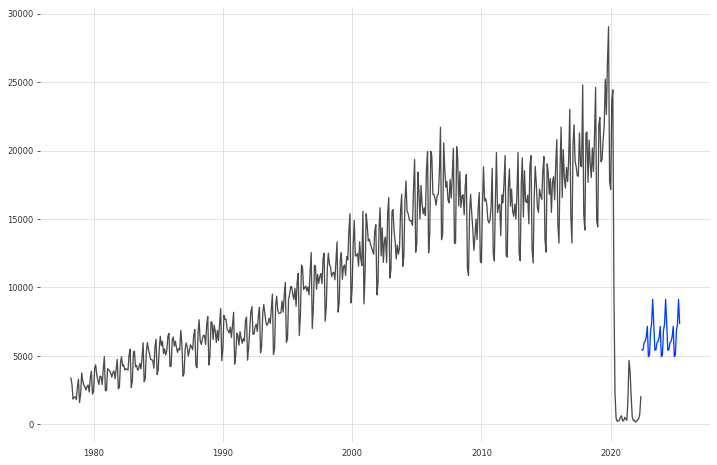

In [14]:
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

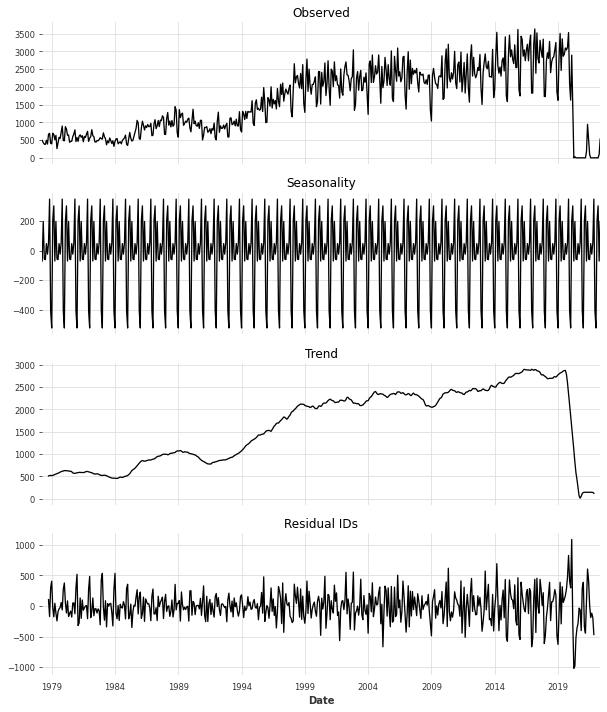

In [15]:
# Business Wellington
y = arrivals['BusinessWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

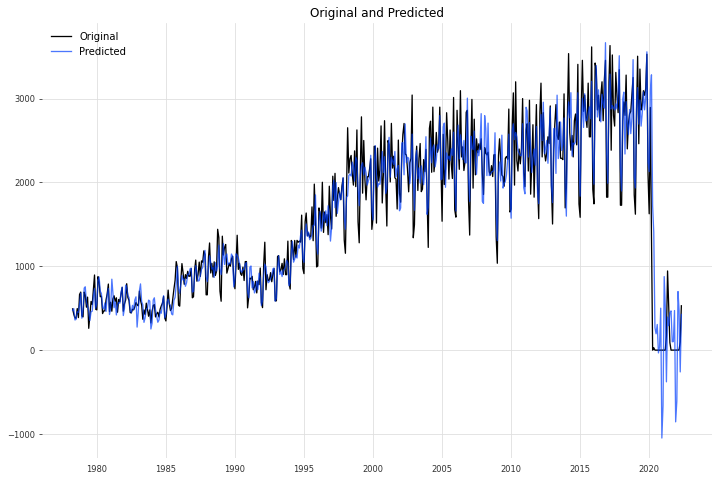

In [16]:
exp = ExponentialSmoothing(y, trend = 'add', seasonal = 'add', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'bh')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [17]:
exp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                       ExponentialSmoothing Model Results                       
================================================================================
Dep. Variable:       BusinessWellington   No. Observations:                  530
Model:             ExponentialSmoothing   SSE                       43476338.261
Optimized:                         True   AIC                           6030.871
Trend:                         Additive   BIC                           6103.510
Seasonal:                      Additive   AICC                          6032.361
Seasonal Periods:                    12   Date:                 Thu, 28 Jul 2022
Box-Cox:                          False   Time:                         22:11:16
Box-Cox Coeff.:                    None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.4589073                alpha                 True
smoothing_trend                0.000000                 beta                 True
smoothing_seasonal            0.1343534                gamma                 True
initial_level                 406.05474                  l.0                 True
initial_trend                 25.072376                  b.0                 True
damping_trend                 0.8767153                  phi                 True
initial_seasons.0             42.417994                  s.0                 True
initial_seasons.1             33.169732                  s.1                 True
initial_seasons.2            -90.349619                  s.2                 True
initial_seasons.3            -111.41120                  s.3                 True
initial_seasons.4            -40.439027                  s.4                 True
initial_seasons.5            -79.027223                  s.5                 True
initial_seasons.6             32.827242                  s.6                 True
initial_seasons.7             104.68883                  s.7                 True
initial_seasons.8            -209.61002                  s.8                 True
initial_seasons.9            -128.64046                  s.9                 True
initial_seasons.10            162.19415                 s.10                 True
initial_seasons.11            193.52019                 s.11                 True
---------------------------------------------------------------------------------
"""

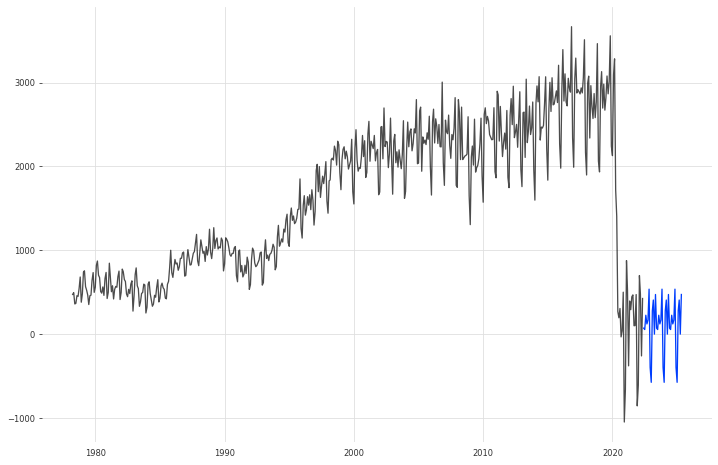

In [18]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(12,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

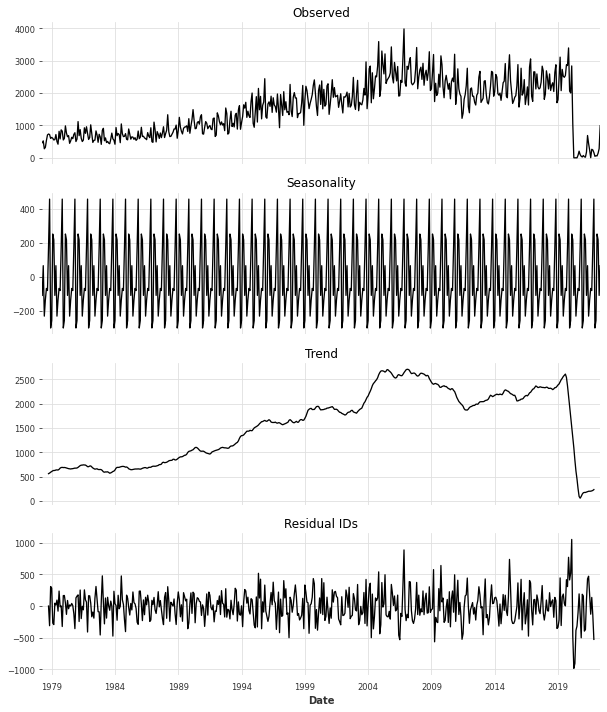

In [19]:
# BUSINESS CHRISTCHURCH
# Pycaret helped us decide that a linear model with deseasonilization and detrending would be the best model to utilize

y = arrivals['BusinessChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [20]:
dftest = adfuller(y, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.5760617670588788
2. P-Value :  0.49560631382433273
3. Num Of Lags :  17
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 512
5. Critical Values :
	 1% :  -3.443186695642769
	 5% :  -2.86720156693697
	 10% :  -2.569785402984619


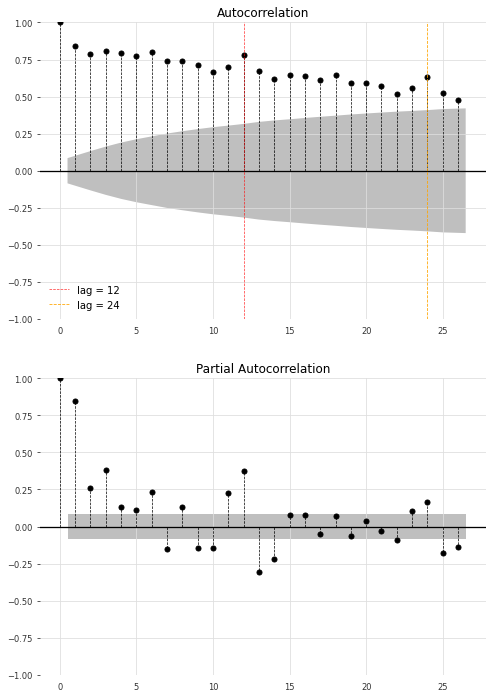

In [21]:
# Due to the linearity of this data, we shall use SARIMAX as it is the combination of Linear Regression and SARIMA 
# Lets first look at the ACF and PACF 

fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [22]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  530
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -3743.933
Date:                            Thu, 28 Jul 2022   AIC                           7495.866
Time:                                    22:12:42   BIC                           7512.950
Sample:                                         0   HQIC                          7502.553
                                            - 530                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5480      0.019    -28.893      0.000      -0.585      -0.511
ar.S.L12       0.9741      0.013     73.777      0.000       0.948       1.000
ma.S.L12      -0.7840      0.038    -20.502      0.000      -0.859      -0.709
sigma2      8.024e+04   3055.030     26.263      0.000    7.42e+04    8.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               595.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.36   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [23]:
model = sarimax.SARIMAX(y, order=(0,1,1), seasonal_order=(1,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:               BusinessChristchurch   No. Observations:                  530
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood               -3743.933
Date:                            Thu, 28 Jul 2022   AIC                           7495.866
Time:                                    22:12:43   BIC                           7512.950
Sample:                                04-01-1978   HQIC                          7502.553
                                     - 05-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5480      0.019    -28.893      0.000      -0.585      -0.511
ar.S.L12       0.9741      0.013     73.777      0.000       0.948       1.000
ma.S.L12      -0.7840      0.038    -20.502      0.000      -0.859      -0.709
sigma2      8.024e+04   3055.030     26.263      0.000    7.42e+04    8.62e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               595.06
Prob(Q):                              0.91   Prob(JB):                         0.00
Heteroskedasticity (H):               5.36   Skew:                            -0.69
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.01
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

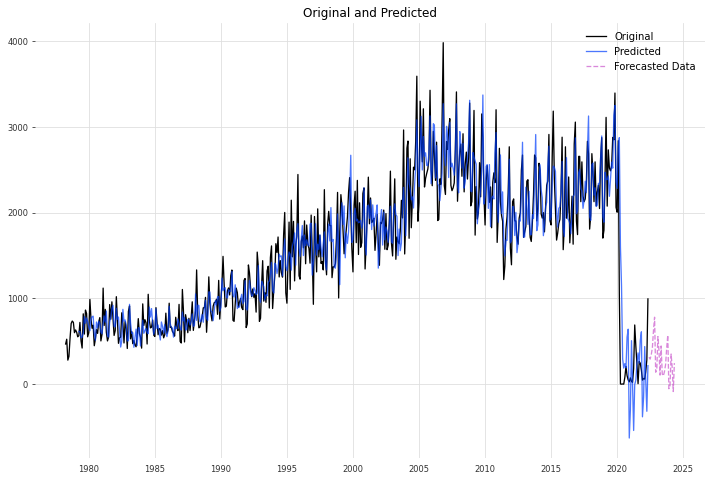

In [24]:

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

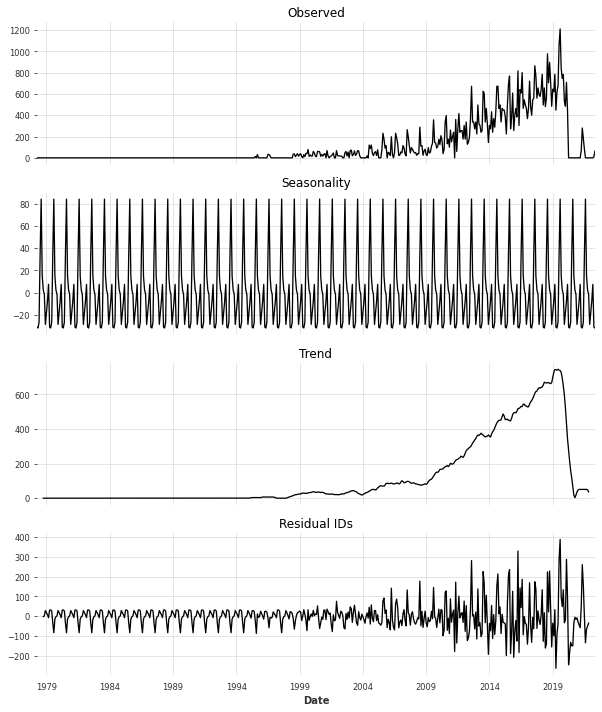

In [25]:
# Business Queenstown using ETS
y = arrivals['BusinessQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

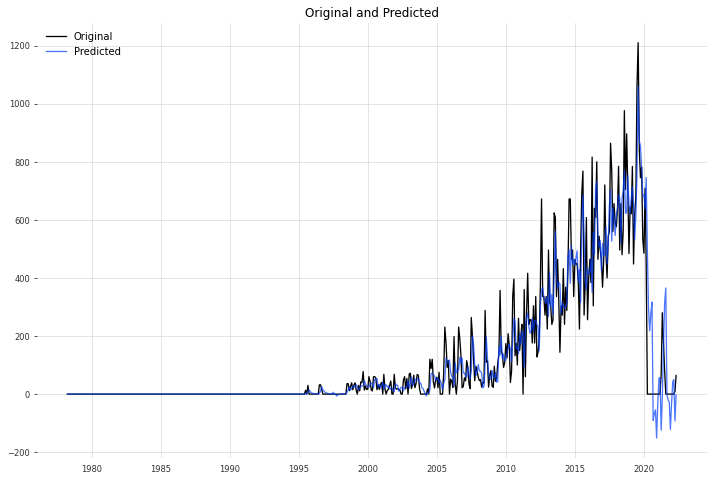

In [26]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [27]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 ETS Results                                  
==============================================================================
Dep. Variable:     BusinessQueenstown   No. Observations:                  530
Model:                      ETS(AAdA)   Log Likelihood               -3085.020
Date:                Thu, 28 Jul 2022   AIC                           6208.039
Time:                        22:12:44   BIC                           6289.224
Sample:                    04-01-1978   HQIC                          6239.816
                         - 05-01-2022   Scale                         6658.878
Covariance Type:               approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4135      0.034     12.211      0.000       0.347       0.480
smoothing_trend      4.135e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.1438      0.025      5.741      0.000       0.095       0.193
damping_trend           0.8000        nan        nan        nan         nan         nan
initial_level       -2.772e-06     80.375  -3.45e-08      1.000    -157.532     157.532
initial_trend        1.153e-05     40.804   2.83e-07      1.000     -79.974      79.974
initial_seasonal.0   6.306e-05     36.608   1.72e-06      1.000     -71.751      71.751
initial_seasonal.1   1.924e-05     36.545   5.26e-07      1.000     -71.627      71.627
initial_seasonal.2  -2.178e-05     36.530  -5.96e-07      1.000     -71.598      71.598
initial_seasonal.3  -7.239e-05     36.607  -1.98e-06      1.000     -71.749      71.749
initial_seasonal.4  -1.286e-05     36.702   -3.5e-07      1.000     -71.934      71.934
initial_seasonal.5  -2.452e-05     36.746  -6.67e-07      1.000     -72.020      72.020
initial_seasonal.6  -1.685e-06     36.537  -4.61e-08      1.000     -71.611      71.611
initial_seasonal.7      0.0002     36.230    5.7e-06      1.000     -71.009      71.009
initial_seasonal.8   7.497e-05     36.245   2.07e-06      1.000     -71.039      71.039
initial_seasonal.9  -9.028e-05     36.237  -2.49e-06      1.000     -71.024      71.024
initial_seasonal.10 -7.609e-05     36.170   -2.1e-06      1.000     -70.892      70.892
initial_seasonal.11          0     36.051          0      1.000     -70.658      70.658
===================================================================================
Ljung-Box (Q):                       49.64   Jarque-Bera (JB):              1508.73
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):          149928.29   Skew:                            -0.07
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 1.44e+17. Standard errors may be unstable.
"""

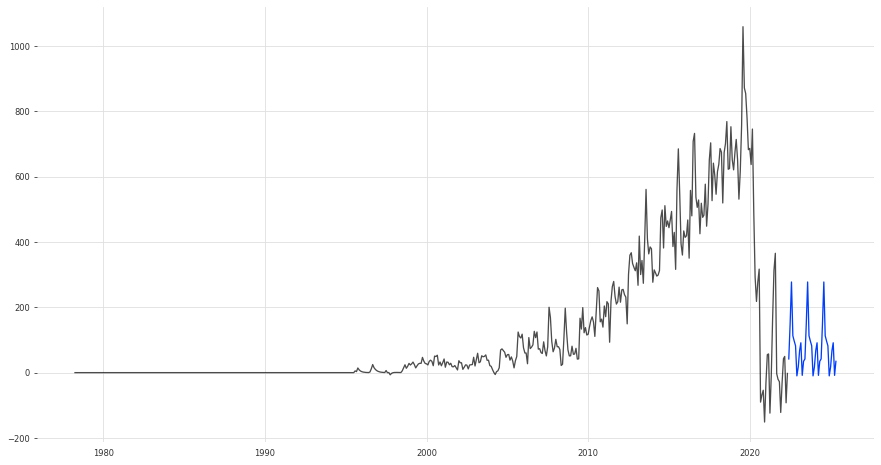

In [28]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

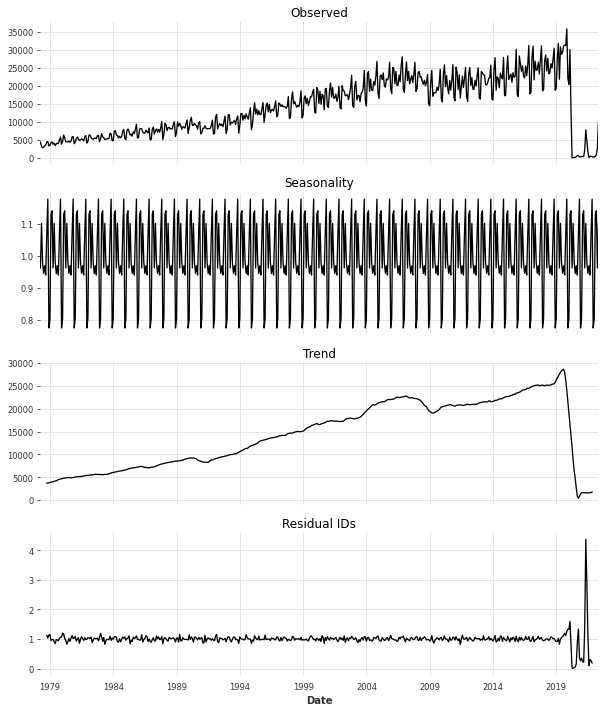

In [29]:
#All BUsiness NZ
y = arrivals['BusinessTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

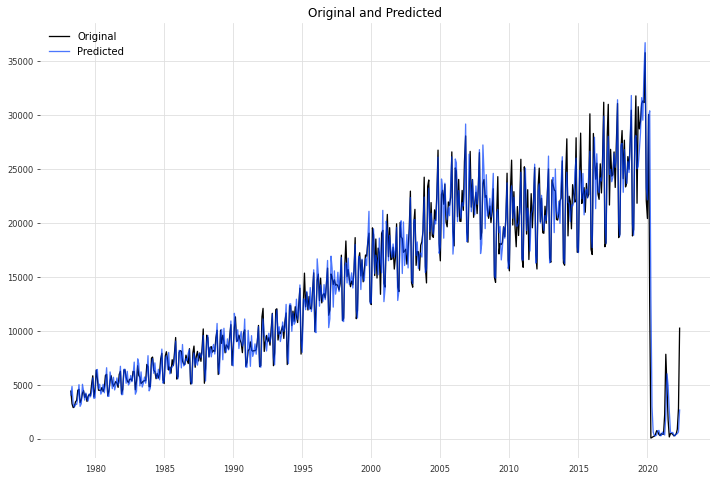

In [30]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', seasonal_periods = 12, damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [31]:
exp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ExponentialSmoothing Model Results                            
===========================================================================================
Dep. Variable:     BusinessTOTAL NEW ZEALAND PORTS   No. Observations:                  530
Model:                        ExponentialSmoothing   SSE                     1339205741.743
Optimized:                                    True   AIC                           7847.507
Trend:                              Multiplicative   BIC                           7920.146
Seasonal:                           Multiplicative   AICC                          7848.997
Seasonal Periods:                               12   Date:                 Thu, 28 Jul 2022
Box-Cox:                                     False   Time:                         22:12:45
Box-Cox Coeff.:                               None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8000939                alpha                 True
smoothing_trend              1.6292e-33                 beta                 True
smoothing_seasonal           1.5256e-21                gamma                 True
initial_level                 3384.6017                  l.0                 True
initial_trend                 0.9947971                  b.0                 True
damping_trend                 0.9950000                  phi                 True
initial_seasons.0             1.1989201                  s.0                 True
initial_seasons.1             1.3474080                  s.1                 True
initial_seasons.2             1.2139435                  s.2                 True
initial_seasons.3             1.2158007                  s.3                 True
initial_seasons.4             1.3181672                  s.4                 True
initial_seasons.5             1.2488464                  s.5                 True
initial_seasons.6             1.3717237                  s.6                 True
initial_seasons.7             1.5880614                  s.7                 True
initial_seasons.8             1.0262887                  s.8                 True
initial_seasons.9             1.0188066                  s.9                 True
initial_seasons.10            1.4664731                 s.10                 True
initial_seasons.11            1.4862698                 s.11                 True
---------------------------------------------------------------------------------
"""

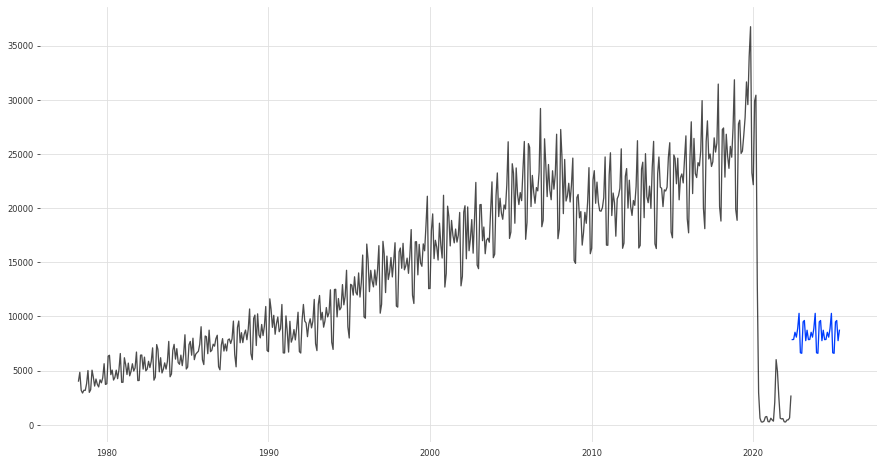

In [32]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

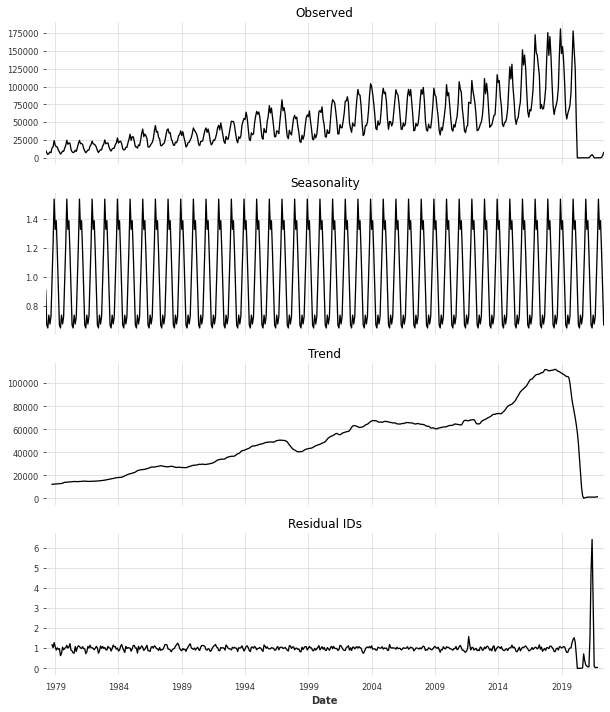

In [33]:
#Holiday/VacationAuckland Exp Smoothing
y = arrivals['Holiday/VacationAuckland']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

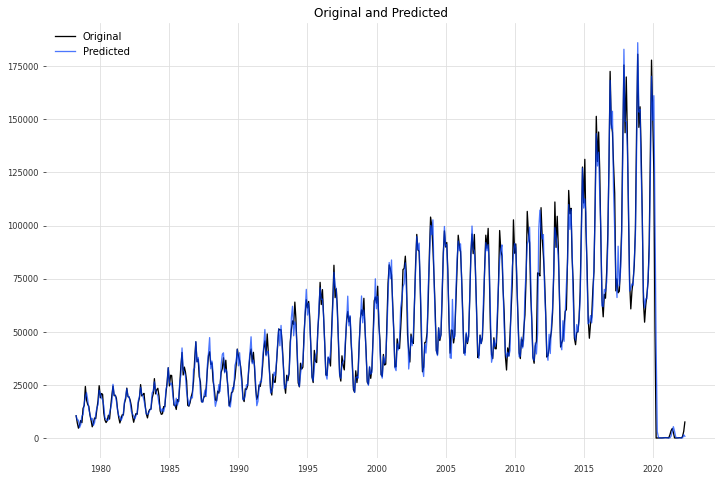

In [34]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [35]:
exp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         ExponentialSmoothing Model Results                         
====================================================================================
Dep. Variable:     Holiday/VacationAuckland   No. Observations:                  530
Model:                 ExponentialSmoothing   SSE                    18702721394.820
Optimized:                             True   AIC                           9244.901
Trend:                       Multiplicative   BIC                           9317.540
Seasonal:                    Multiplicative   AICC                          9246.391
Seasonal Periods:                        12   Date:                 Thu, 28 Jul 2022
Box-Cox:                              False   Time:                         22:12:47
Box-Cox Coeff.:                        None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               0.8937923                alpha                 True
smoothing_trend              3.2978e-21                 beta                 True
smoothing_seasonal            0.1062077                gamma                 True
initial_level                 11241.136                  l.0                 True
initial_trend                 1.0468350                  b.0                 True
damping_trend                 0.9723339                  phi                 True
initial_seasons.0             0.8899876                  s.0                 True
initial_seasons.1             0.6852941                  s.1                 True
initial_seasons.2             0.7585078                  s.2                 True
initial_seasons.3             0.7086758                  s.3                 True
initial_seasons.4             0.7150556                  s.4                 True
initial_seasons.5             0.8885682                  s.5                 True
initial_seasons.6             1.2379975                  s.6                 True
initial_seasons.7             1.4310471                  s.7                 True
initial_seasons.8             1.7503766                  s.8                 True
initial_seasons.9             1.5164107                  s.9                 True
initial_seasons.10            1.4559295                 s.10                 True
initial_seasons.11            1.2031459                 s.11                 True
---------------------------------------------------------------------------------
"""

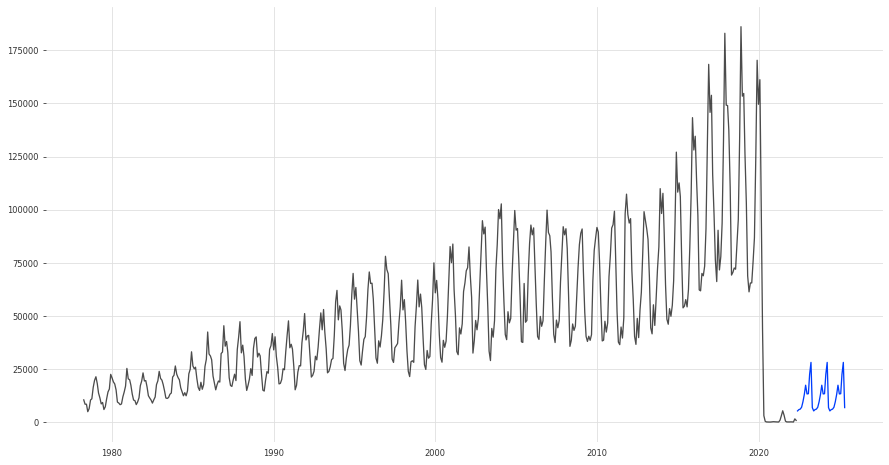

In [36]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

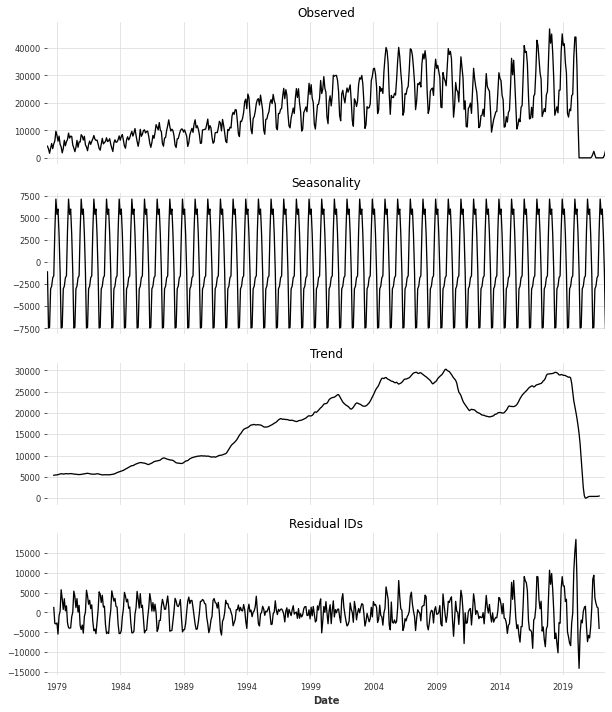

In [37]:
#Holiday/VacationChristchurch ARIMA
y = arrivals['Holiday/VacationChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

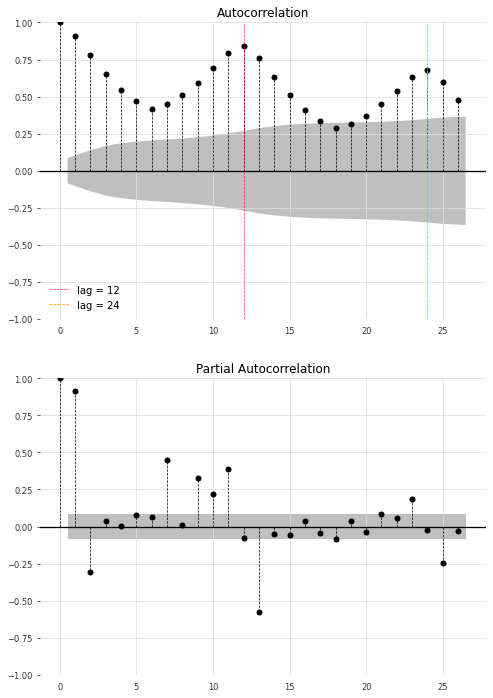

In [38]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [39]:
dftest = adfuller(y, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -1.630032621292153
2. P-Value :  0.46747363801463915
3. Num Of Lags :  12
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 517
5. Critical Values :
	 1% :  -3.443061925077973
	 5% :  -2.8671466525252014
	 10% :  -2.5697561378507907


In [40]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                       y   No. Observations:                  530
Model:             SARIMAX(2, 1, 1)x(1, 0, [1, 2], 12)   Log Likelihood               -4895.556
Date:                                 Thu, 28 Jul 2022   AIC                           9805.112
Time:                                         22:14:15   BIC                           9835.009
Sample:                                              0   HQIC                          9816.815
                                                 - 530                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9126      0.030     30.702      0.000       0.854       0.971
ar.L2         -0.0982      0.029     -3.356      0.001      -0.156      -0.041
ma.L1         -0.9428      0.024    -39.617      0.000      -0.989      -0.896
ar.S.L12       0.9587      0.015     65.241      0.000       0.930       0.988
ma.S.L12      -0.5216      0.038    -13.787      0.000      -0.596      -0.447
ma.S.L24      -0.1127      0.044     -2.564      0.010      -0.199      -0.027
sigma2      6.384e+06   2.51e-09   2.54e+15      0.000    6.38e+06    6.38e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):               651.72
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               9.31   Skew:                            -0.82
Prob(H) (two-sided):                  0.00   Kurtosis:                         8.18
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.85e+30. Standard errors may be unstable.
"""

In [41]:
model = sarimax.SARIMAX(y, order=(0,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:         Holiday/VacationChristchurch   No. Observations:                  530
Model:             SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -4909.268
Date:                              Thu, 28 Jul 2022   AIC                           9826.536
Time:                                      22:14:15   BIC                           9843.620
Sample:                                  04-01-1978   HQIC                          9833.224
                                       - 05-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.1269      0.087     12.934      0.000       0.956       1.298
ar.S.L24      -0.1596      0.073     -2.176      0.030      -0.303      -0.016
ma.S.L12      -0.6948      0.086     -8.078      0.000      -0.863      -0.526
sigma2      6.764e+06   3.03e-09   2.23e+15      0.000    6.76e+06    6.76e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               550.66
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               9.48   Skew:                            -0.32
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.96
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.88e+30. Standard errors may be unstable.
"""

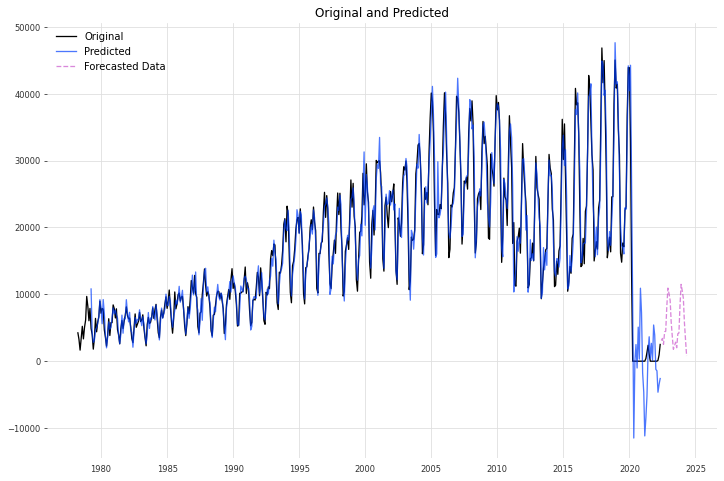

In [42]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

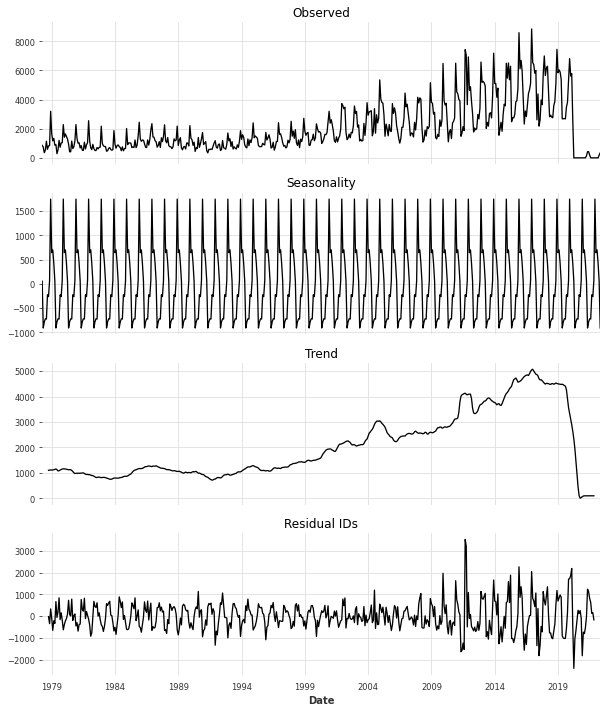

In [43]:
#Holiday/VacationWellington ETS
y = arrivals['Holiday/VacationWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

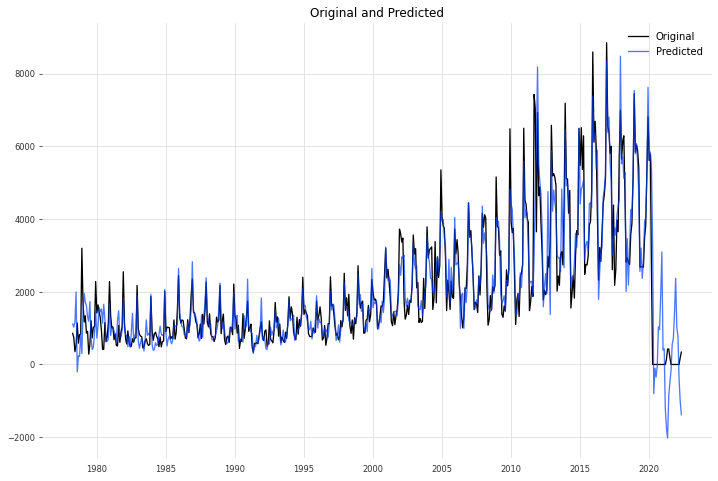

In [44]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [45]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationWellington   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4182.931
Date:                        Thu, 28 Jul 2022   AIC                           8403.862
Time:                                22:14:16   BIC                           8485.047
Sample:                            04-01-1978   HQIC                          8435.639
                                 - 05-01-2022   Scale                       419478.935
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.4368      0.080      5.443      0.000       0.280       0.594
smoothing_trend      4.368e-05      0.006      0.007      0.994      -0.012       0.012
smoothing_seasonal      0.3788      0.060      6.319      0.000       0.261       0.496
damping_trend           0.8285        nan        nan        nan         nan         nan
initial_level        1112.4555    577.007      1.928      0.054     -18.458    2243.369
initial_trend           1.0599    286.432      0.004      0.997    -560.337     562.457
initial_seasonal.0   -159.2915    424.081     -0.376      0.707    -990.474     671.891
initial_seasonal.1   -262.9998    421.741     -0.624      0.533   -1089.598     563.598
initial_seasonal.2   -652.5100    446.834     -1.460      0.144   -1528.289     223.269
initial_seasonal.3   -572.7699    554.582     -1.033      0.302   -1659.731     514.191
initial_seasonal.4    -22.1460    423.162     -0.052      0.958    -851.528     807.236
initial_seasonal.5   -401.7708    422.010     -0.952      0.341   -1228.895     425.353
initial_seasonal.6   -231.6251    420.174     -0.551      0.581   -1055.152     591.902
initial_seasonal.7    -89.2500    423.383     -0.211      0.833    -919.066     740.566
initial_seasonal.8   1469.4990    571.892      2.570      0.010     348.611    2590.387
initial_seasonal.9    286.9579    442.143      0.649      0.516    -579.626    1153.541
initial_seasonal.10    23.7499    417.542      0.057      0.955    -794.617     842.116
initial_seasonal.11          0    420.273          0      1.000    -823.719     823.719
===================================================================================
Ljung-Box (Q):                      157.56   Jarque-Bera (JB):              1616.90
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               4.72   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.54
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.93e+16. Standard errors may be unstable.
"""

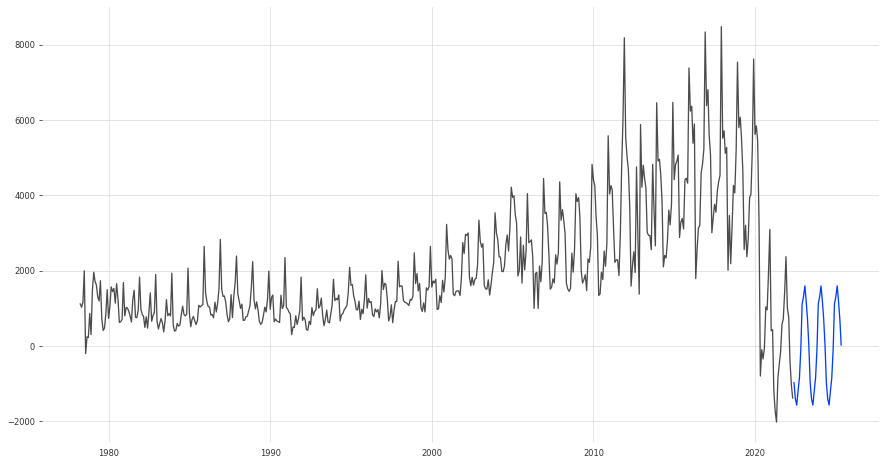

In [46]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

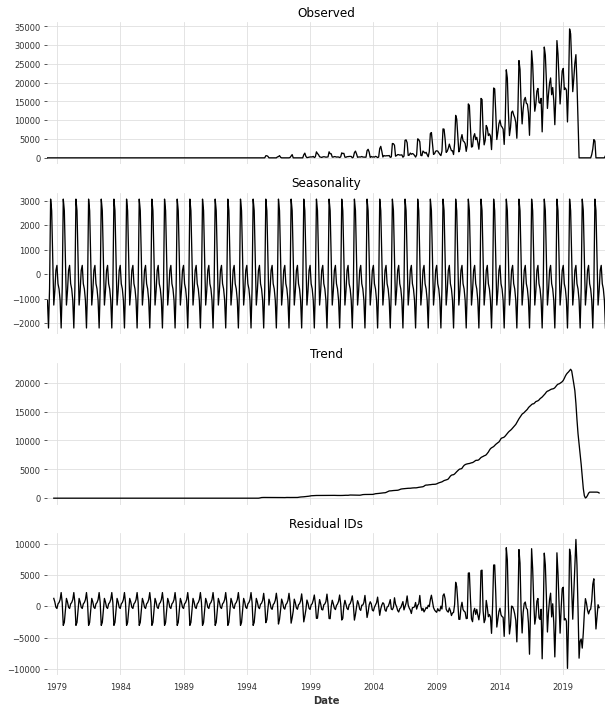

In [47]:
#Holiday/VacationQueenstown ETS
y = arrivals['Holiday/VacationQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

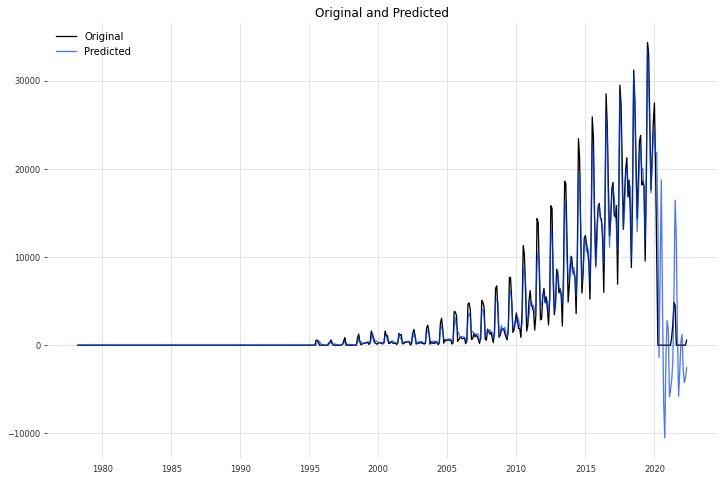

In [48]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [49]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationQueenstown   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4740.268
Date:                        Thu, 28 Jul 2022   AIC                           9518.535
Time:                                22:14:17   BIC                           9599.720
Sample:                            04-01-1978   HQIC                          9550.312
                                 - 05-01-2022   Scale                      3436365.816
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5929      0.044     13.409      0.000       0.506       0.680
smoothing_trend      5.929e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.4071      0.039     10.545      0.000       0.331       0.483
damping_trend           0.8664        nan        nan        nan         nan         nan
initial_level        1.621e-07   1603.814   1.01e-10      1.000   -3143.418    3143.418
initial_trend        5.418e-08    813.070   6.66e-11      1.000   -1593.587    1593.587
initial_seasonal.0  -2.194e-06   1157.737   -1.9e-09      1.000   -2269.122    2269.122
initial_seasonal.1   -1.27e-06   1155.045   -1.1e-09      1.000   -2263.847    2263.847
initial_seasonal.2     1.6e-06   1152.562   1.39e-09      1.000   -2258.980    2258.980
initial_seasonal.3   7.747e-07   1150.130   6.74e-10      1.000   -2254.212    2254.212
initial_seasonal.4  -2.707e-06   1147.446  -2.36e-09      1.000   -2248.954    2248.954
initial_seasonal.5  -5.419e-06   1144.431  -4.73e-09      1.000   -2243.044    2243.044
initial_seasonal.6   2.061e-06   1141.440   1.81e-09      1.000   -2237.182    2237.182
initial_seasonal.7   9.799e-06   1139.147    8.6e-09      1.000   -2232.688    2232.688
initial_seasonal.8   1.199e-05   1138.222   1.05e-08      1.000   -2230.874    2230.874
initial_seasonal.9  -2.436e-06   1139.161  -2.14e-09      1.000   -2232.715    2232.715
initial_seasonal.10 -8.388e-06   1142.464  -7.34e-09      1.000   -2239.188    2239.188
initial_seasonal.11          0   1148.984          0      1.000   -2251.967    2251.967
===================================================================================
Ljung-Box (Q):                      375.54   Jarque-Bera (JB):             31912.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           24305.61   Skew:                            -3.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+17. Standard errors may be unstable.
"""

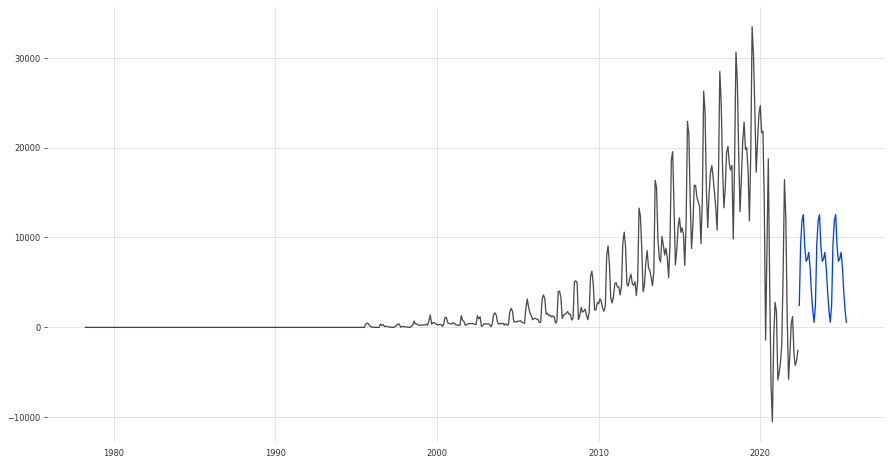

In [50]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

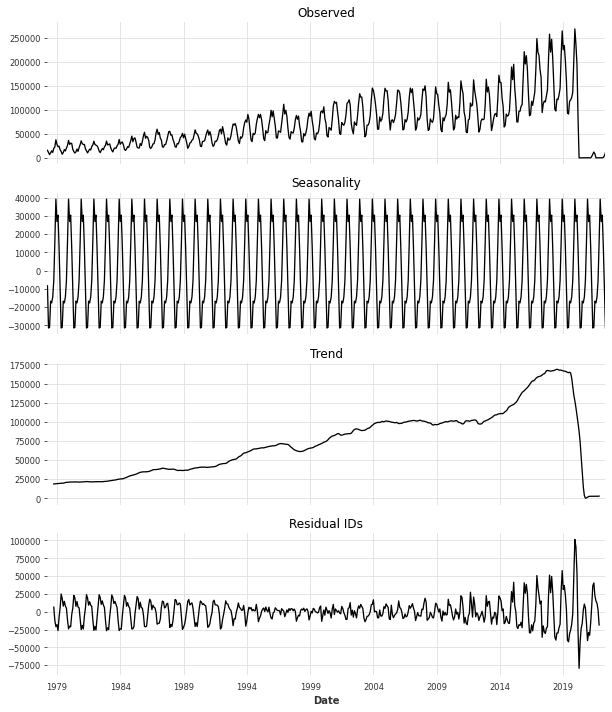

In [51]:

#Holiday/VacationTOTAL NEW ZEALAND PORT
y = arrivals[['Holiday/VacationTOTAL NEW ZEALAND PORTS']]

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [52]:
ts = TimeSeries.from_series(y)

In [53]:
model = tbats.BATS()
model_fit = model.fit(ts)

In [54]:
y_pred = model_fit.predict(36)

In [55]:
y_pred_df = y_pred.pd_dataframe()
y_pred_df

component   Holiday/VacationTOTAL NEW ZEALAND PORTS
Date                                               
2022-06-01                             13938.961425
2022-07-01                             15005.916951
2022-08-01                              7603.064232
2022-09-01                              4434.934225
2022-10-01                              2106.729295
2022-11-01                              6893.901863
2022-12-01                             19698.616632
2023-01-01                             21845.159399
2023-02-01                             25814.824757
2023-03-01                             20558.843612
2023-04-01                              9796.801034
2023-05-01                              3906.875940
2023-06-01                              1646.615592
2023-07-01                              1578.462430
2023-08-01                               294.188278
2023-09-01                              1042.332909
2023-10-01                              2495.843291
2023-11-01                             12499.023334
2023-12-01                             31771.149808
2024-01-01                             33576.465252
2024-02-01                             34077.289187
2024-03-01                             23028.848236
2024-04-01                              8356.585784
2024-05-01                              1787.353364
2024-06-01                               165.570195
2024-07-01                               289.045918
2024-08-01                                 0.383722
2024-09-01                               943.970000
2024-10-01                              3262.159780
2024-11-01                             14872.058858
2024-12-01                             35395.368875
2025-01-01                             36258.436776
2025-02-01                             35295.012434
2025-03-01                             22754.238581
2025-04-01                              7560.697707
2025-05-01                              1263.556023

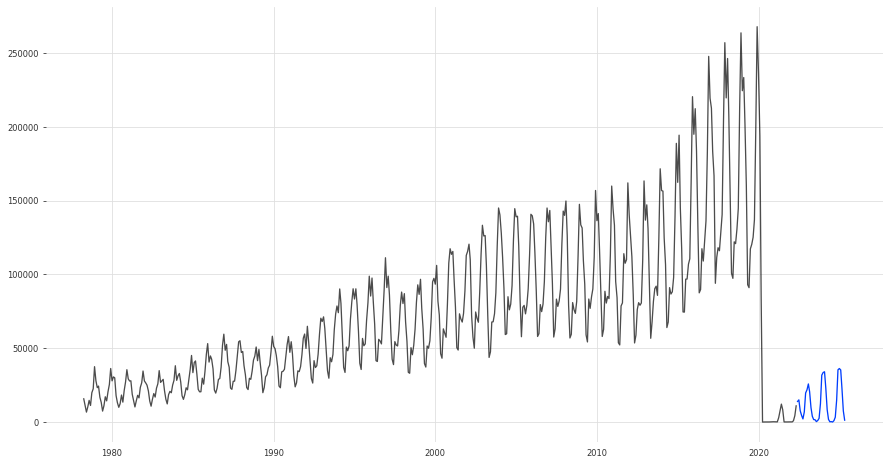

In [56]:
plt.figure(figsize=(15,8))

plt.plot(y, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_pred_df)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

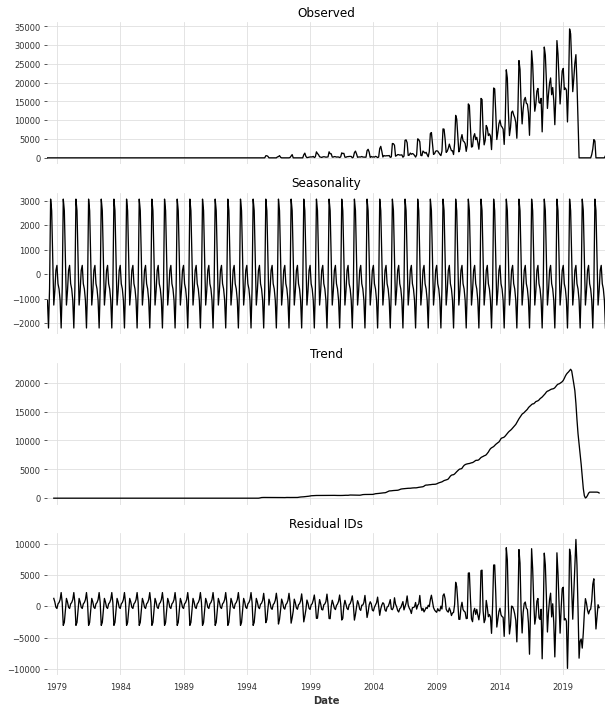

In [57]:
#TOTAL ALL TRAVEL PURPOSESAuckland ETS
y = arrivals['Holiday/VacationQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

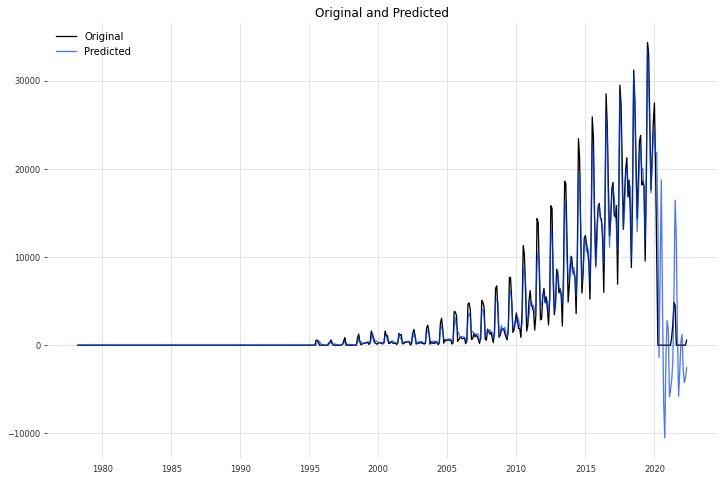

In [58]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [59]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ETS Results                                      
======================================================================================
Dep. Variable:     Holiday/VacationQueenstown   No. Observations:                  530
Model:                              ETS(AAdA)   Log Likelihood               -4740.268
Date:                        Thu, 28 Jul 2022   AIC                           9518.535
Time:                                22:14:43   BIC                           9599.720
Sample:                            04-01-1978   HQIC                          9550.312
                                 - 05-01-2022   Scale                      3436365.816
Covariance Type:                       approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.5929      0.044     13.409      0.000       0.506       0.680
smoothing_trend      5.929e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.4071      0.039     10.545      0.000       0.331       0.483
damping_trend           0.8664        nan        nan        nan         nan         nan
initial_level        1.621e-07   1603.814   1.01e-10      1.000   -3143.418    3143.418
initial_trend        5.418e-08    813.070   6.66e-11      1.000   -1593.587    1593.587
initial_seasonal.0  -2.194e-06   1157.737   -1.9e-09      1.000   -2269.122    2269.122
initial_seasonal.1   -1.27e-06   1155.045   -1.1e-09      1.000   -2263.847    2263.847
initial_seasonal.2     1.6e-06   1152.562   1.39e-09      1.000   -2258.980    2258.980
initial_seasonal.3   7.747e-07   1150.130   6.74e-10      1.000   -2254.212    2254.212
initial_seasonal.4  -2.707e-06   1147.446  -2.36e-09      1.000   -2248.954    2248.954
initial_seasonal.5  -5.419e-06   1144.431  -4.73e-09      1.000   -2243.044    2243.044
initial_seasonal.6   2.061e-06   1141.440   1.81e-09      1.000   -2237.182    2237.182
initial_seasonal.7   9.799e-06   1139.147    8.6e-09      1.000   -2232.688    2232.688
initial_seasonal.8   1.199e-05   1138.222   1.05e-08      1.000   -2230.874    2230.874
initial_seasonal.9  -2.436e-06   1139.161  -2.14e-09      1.000   -2232.715    2232.715
initial_seasonal.10 -8.388e-06   1142.464  -7.34e-09      1.000   -2239.188    2239.188
initial_seasonal.11          0   1148.984          0      1.000   -2251.967    2251.967
===================================================================================
Ljung-Box (Q):                      375.54   Jarque-Bera (JB):             31912.13
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):           24305.61   Skew:                            -3.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        40.27
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.96e+17. Standard errors may be unstable.
"""

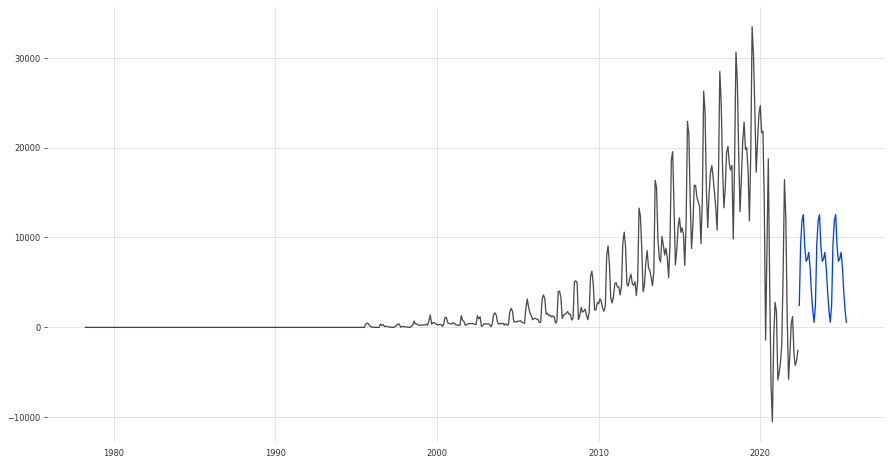

In [60]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

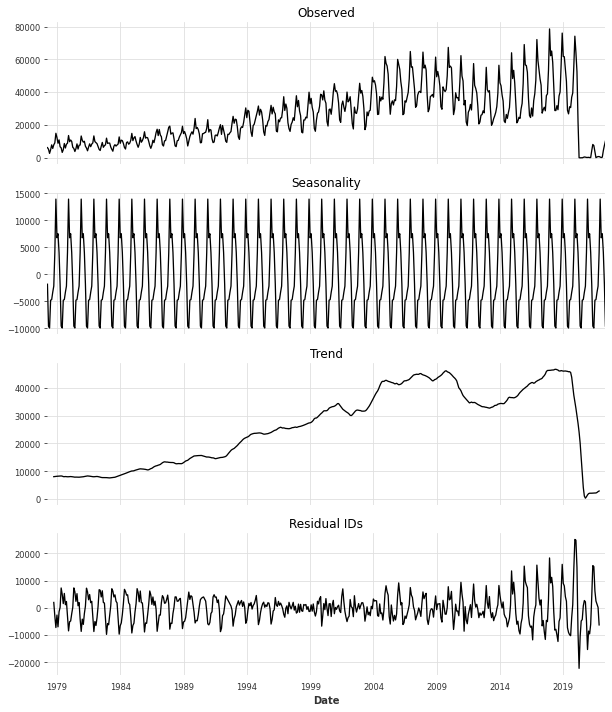

In [61]:
#TOTAL ALL TRAVEL PURPOSESChristchurch arima
y = arrivals['TOTAL ALL TRAVEL PURPOSESChristchurch']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

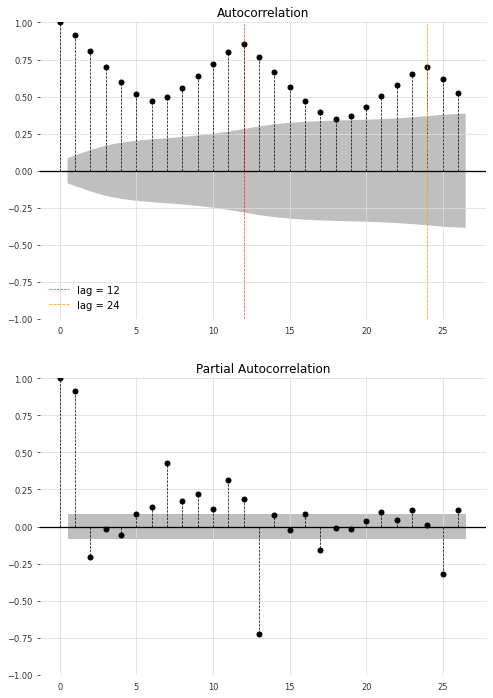

In [62]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [63]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  530
Model:             SARIMAX(0, 1, 2)x(2, 0, [1], 12)   Log Likelihood               -5080.254
Date:                              Thu, 28 Jul 2022   AIC                          10172.507
Time:                                      22:15:56   BIC                          10198.133
Sample:                                           0   HQIC                         10182.539
                                              - 530                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0737      0.020      3.766      0.000       0.035       0.112
ma.L2         -0.0909      0.027     -3.429      0.001      -0.143      -0.039
ar.S.L12       1.1279      0.092     12.316      0.000       0.948       1.307
ar.S.L24      -0.1611      0.078     -2.065      0.039      -0.314      -0.008
ma.S.L12      -0.6581      0.093     -7.060      0.000      -0.841      -0.475
sigma2      1.251e+07   4.97e-09   2.52e+15      0.000    1.25e+07    1.25e+07
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1361.23
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):              11.17   Skew:                            -0.37
Prob(H) (two-sided):                  0.00   Kurtosis:                        10.82
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.97e+31. Standard errors may be unstable.
"""

In [64]:
model = sarimax.SARIMAX(y, order=(0,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                         SARIMAX Results                                         
=================================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESChristchurch   No. Observations:                  530
Model:                  SARIMAX(0, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -5083.018
Date:                                   Thu, 28 Jul 2022   AIC                          10174.036
Time:                                           22:15:56   BIC                          10191.120
Sample:                                       04-01-1978   HQIC                         10180.723
                                            - 05-01-2022                                         
Covariance Type:                                     opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12       1.1211      0.091     12.320      0.000       0.943       1.299
ar.S.L24      -0.1553      0.078     -1.995      0.046      -0.308      -0.003
ma.S.L12      -0.6525      0.092     -7.104      0.000      -0.832      -0.472
sigma2      1.319e+07   4.04e-09   3.27e+15      0.000    1.32e+07    1.32e+07
===================================================================================
Ljung-Box (L1) (Q):                   2.17   Jarque-Bera (JB):              1692.43
Prob(Q):                              0.14   Prob(JB):                         0.00
Heteroskedasticity (H):              11.95   Skew:                            -0.46
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.71
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.13e+31. Standard errors may be unstable.
"""

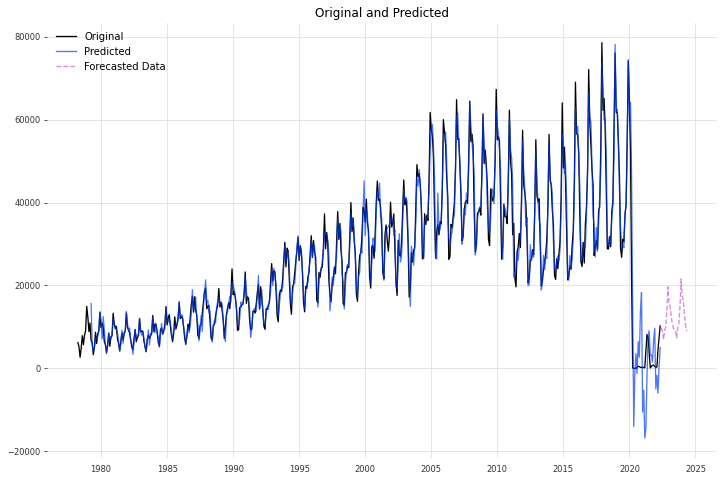

In [65]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

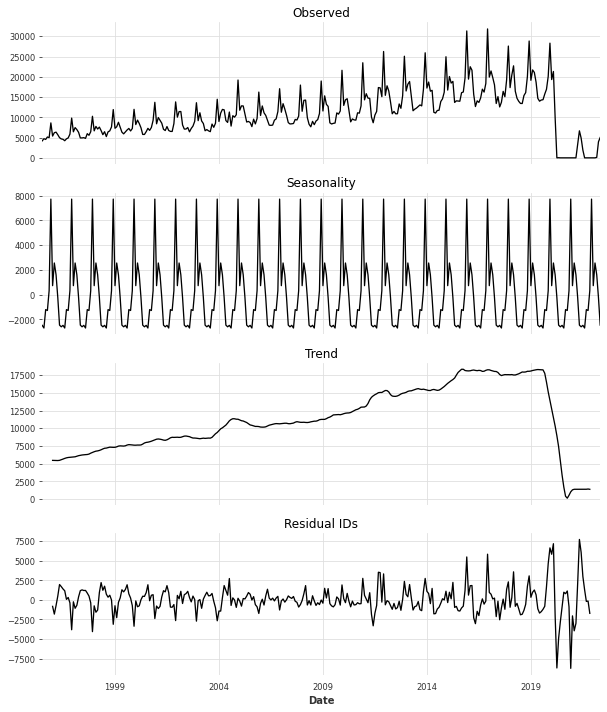

In [66]:
#TOTAL ALL TRAVEL PURPOSESWellington ETS
y = arrivals['TOTAL ALL TRAVEL PURPOSESWellington']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

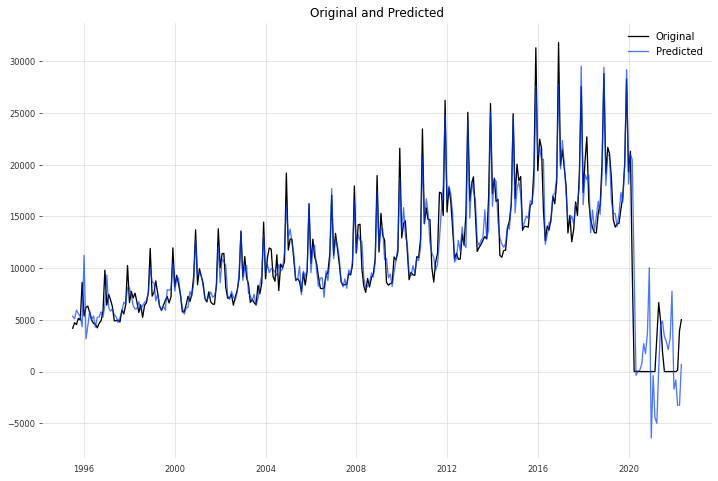

In [67]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', damped_trend = True, seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [68]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                          ETS Results                                          
===============================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESWellington   No. Observations:                  323
Model:                                       ETS(AAdA)   Log Likelihood               -2901.944
Date:                                 Thu, 28 Jul 2022   AIC                           5841.887
Time:                                         22:15:57   BIC                           5913.663
Sample:                                     07-01-1995   HQIC                          5870.539
                                          - 05-01-2022   Scale                      3725882.171
Covariance Type:                                approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.6671        nan        nan        nan         nan         nan
smoothing_trend      6.671e-05      0.002      0.036      0.971      -0.004       0.004
smoothing_seasonal      0.3328        nan        nan        nan         nan         nan
damping_trend           0.8258        nan        nan        nan         nan         nan
initial_level        5319.2194   1851.831      2.872      0.004    1689.698    8948.741
initial_trend          50.8843   1172.968      0.043      0.965   -2248.091    2349.859
initial_seasonal.0    231.3437   1078.254      0.215      0.830   -1881.994    2344.682
initial_seasonal.1   -143.5937    997.574     -0.144      0.886   -2098.803    1811.616
initial_seasonal.2    594.7604    898.825      0.662      0.508   -1166.904    2356.425
initial_seasonal.3    418.5104   1005.380      0.416      0.677   -1551.998    2389.019
initial_seasonal.4   1239.3021   1044.727      1.186      0.236    -808.326    3286.930
initial_seasonal.5   5415.5520        nan        nan        nan         nan         nan
initial_seasonal.6   1371.2501    364.719      3.760      0.000     656.413    2086.087
initial_seasonal.7   2161.6146   1032.435      2.094      0.036     138.079    4185.150
initial_seasonal.8   2135.6562   1042.515      2.049      0.041      92.364    4178.949
initial_seasonal.9   1569.1562    999.604      1.570      0.116    -390.032    3528.344
initial_seasonal.10   494.3542    978.113      0.505      0.613   -1422.712    2411.421
initial_seasonal.11          0   1004.803          0      1.000   -1969.377    1969.377
===================================================================================
Ljung-Box (Q):                       56.28   Jarque-Bera (JB):              1032.79
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               5.24   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                        11.61
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 3.88e+16. Standard errors may be unstable.
"""

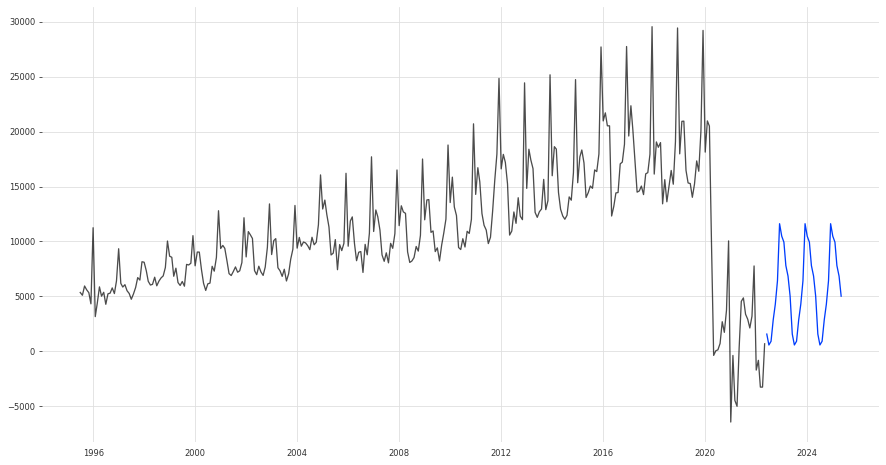

In [69]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

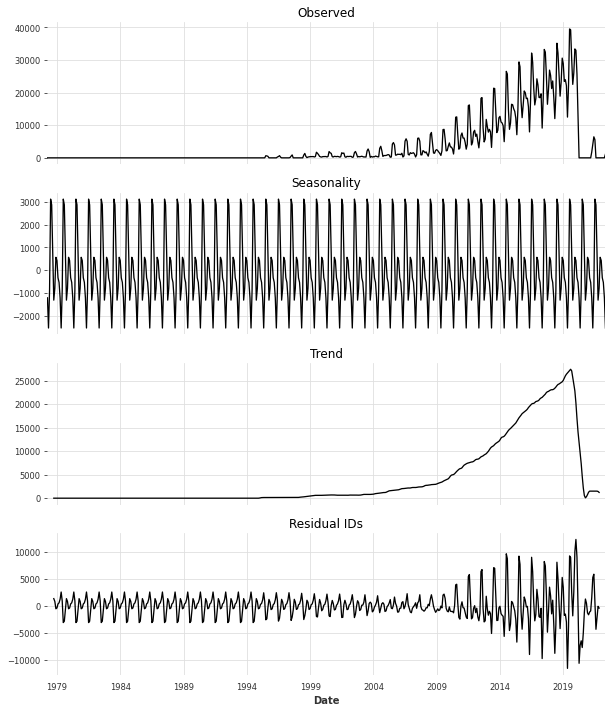

In [70]:
#TOTAL ALL TRAVEL PURPOSESQueenstown auto_arima
y = arrivals['TOTAL ALL TRAVEL PURPOSESQueenstown']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

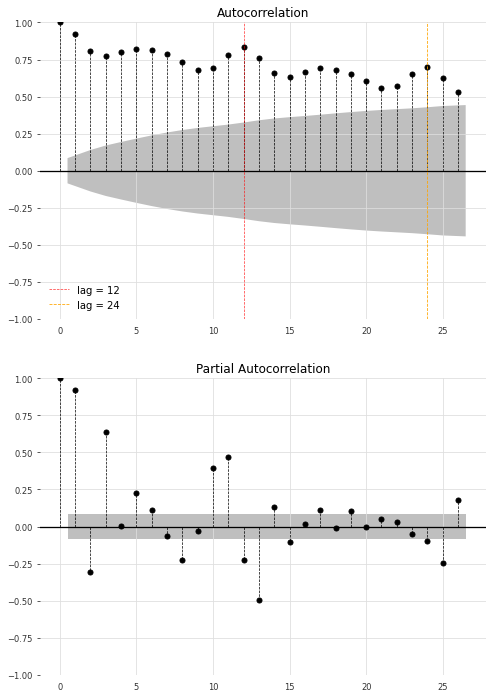

In [71]:
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [72]:
#I will use auto_arima in order to determine ARIMA orders
auto_arima(y, m=12, method = 'cg', information_criterion = 'bic', error_action = 'ignore').summary()

C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  530
Model:             SARIMAX(2, 1, 0)x(1, 0, [1], 12)   Log Likelihood               -4726.311
Date:                              Thu, 28 Jul 2022   AIC                           9462.621
Time:                                      22:22:34   BIC                           9483.976
Sample:                                           0   HQIC                          9470.981
                                              - 530                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4087      0.027     15.127      0.000       0.356       0.462
ar.L2         -0.6443      0.039    -16.668      0.000      -0.720      -0.569
ar.S.L12       0.9159      0.023     39.157      0.000       0.870       0.962
ma.S.L12      -0.4167      0.055     -7.558      0.000      -0.525      -0.309
sigma2      5.331e+06   2.45e+05     21.796      0.000    4.85e+06    5.81e+06
===================================================================================
Ljung-Box (L1) (Q):                   6.16   Jarque-Bera (JB):             26874.34
Prob(Q):                              0.01   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -2.61
Prob(H) (two-sided):                  0.00   Kurtosis:                        37.53
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [73]:
model = sarimax.SARIMAX(y, order=(2,1,0), seasonal_order=(2,0,1,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

model_fit.summary()

C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\lutim\AppData\Roaming\Python\Python39\site-packages\statsmodels\tsa\stattools.py:1346: RuntimeWarning: divide by zero encountered in true_divide
  test_statistic = numer_squared_sum / denom_squared_sum


<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESQueenstown   No. Observations:                  530
Model:                SARIMAX(2, 1, 0)x(2, 0, [1], 12)   Log Likelihood               -4649.164
Date:                                 Thu, 28 Jul 2022   AIC                           9310.328
Time:                                         22:22:36   BIC                           9335.954
Sample:                                     04-01-1978   HQIC                          9320.359
                                          - 05-01-2022                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3254      0.013     24.190      0.000       0.299       0.352
ar.L2         -0.4032      0.017    -23.500      0.000      -0.437      -0.370
ar.S.L12       0.1672      0.065      2.566      0.010       0.040       0.295
ar.S.L24       0.5553      0.047     11.903      0.000       0.464       0.647
ma.S.L12       0.3088      0.079      3.910      0.000       0.154       0.464
sigma2      2.466e+06   5.54e+04     44.478      0.000    2.36e+06    2.57e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.03   Jarque-Bera (JB):              9285.64
Prob(Q):                              0.87   Prob(JB):                         0.00
Heteroskedasticity (H):                inf   Skew:                            -1.74
Prob(H) (two-sided):                  0.00   Kurtosis:                        23.23
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

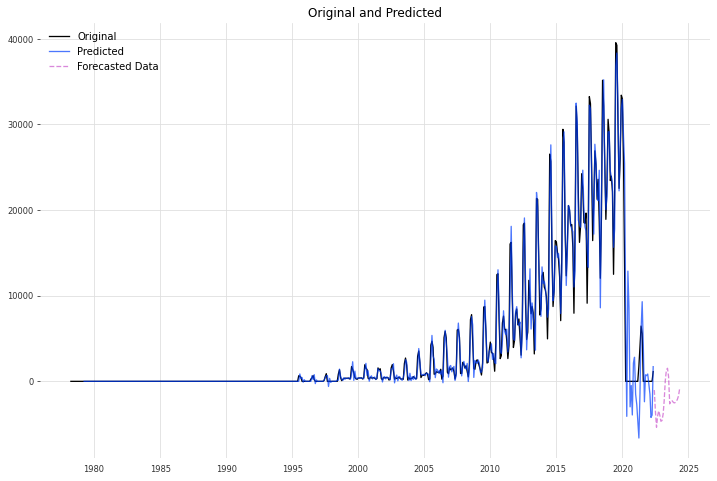

In [74]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

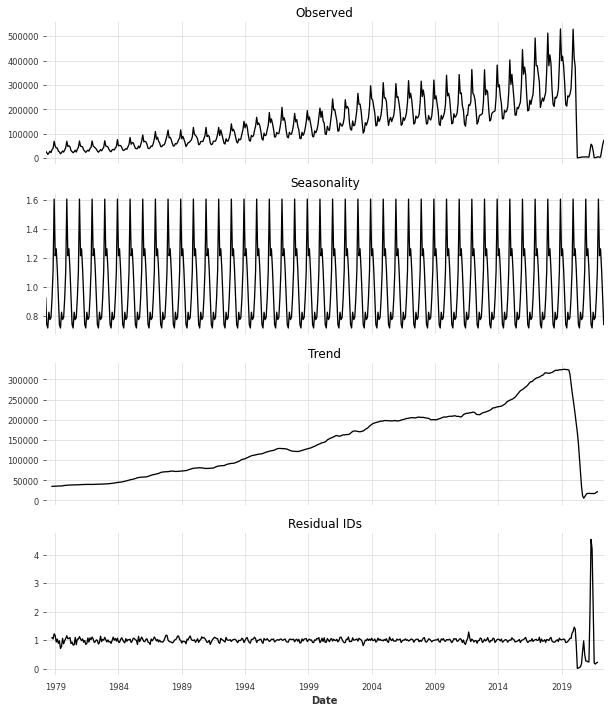

In [75]:
#TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS
y = arrivals['TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS']

res = seasonal_decompose(y, model='mul')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

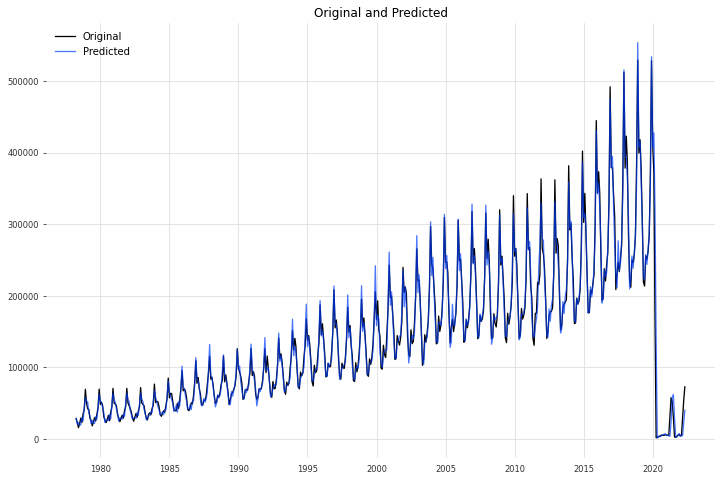

In [76]:
exp = ExponentialSmoothing(y, trend = 'mul', seasonal = 'mul', damped_trend = True)
exp_fit = exp.fit(method = 'ls')

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()
plt.show()

In [77]:
exp_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     ExponentialSmoothing Model Results                                     
============================================================================================================
Dep. Variable:     TOTAL ALL TRAVEL PURPOSESTOTAL NEW ZEALAND PORTS   No. Observations:                  530
Model:                                         ExponentialSmoothing   SSE                    99266246002.963
Optimized:                                                     True   AIC                          10129.543
Trend:                                               Multiplicative   BIC                          10202.182
Seasonal:                                            Multiplicative   AICC                         10131.033
Seasonal Periods:                                                12   Date:                 Thu, 28 Jul 2022
Box-Cox:                                                      False   Time:                         22:22:38
Box-Cox Coeff.:                                                None                                         
=================================================================================
                          coeff                 code              optimized      
---------------------------------------------------------------------------------
smoothing_level               1.0000000                alpha                 True
smoothing_trend              1.3389e-34                 beta                 True
smoothing_seasonal           6.7246e-11                gamma                 True
initial_level                 22985.637                  l.0                 True
initial_trend                 0.9910733                  b.0                 True
damping_trend                 0.9950000                  phi                 True
initial_seasons.0             1.2521270                  s.0                 True
initial_seasons.1             0.9263748                  s.1                 True
initial_seasons.2             0.9385841                  s.2                 True
initial_seasons.3             1.1330271                  s.3                 True
initial_seasons.4             1.0812010                  s.4                 True
initial_seasons.5             1.1394889                  s.5                 True
initial_seasons.6             1.2504315                  s.6                 True
initial_seasons.7             1.5737753                  s.7                 True
initial_seasons.8             2.2598168                  s.8                 True
initial_seasons.9             1.7421885                  s.9                 True
initial_seasons.10            1.8149606                 s.10                 True
initial_seasons.11            1.5777899                 s.11                 True
---------------------------------------------------------------------------------
"""

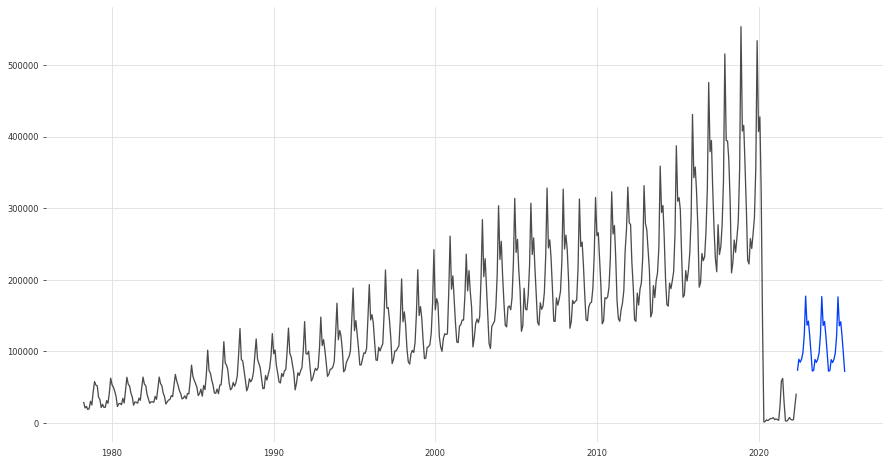

In [78]:
y_fore = exp_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(exp_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

# 2.0 Accomodation-Data

In [80]:
accomodations = pd.read_csv('../NZ Data/Accomodation Data Cleaned.csv', skipinitialspace = True, parse_dates = True, \
                       index_col = 0)
accomodations.head()

TotalNorthlandCapacity  TotalNorthlandOccupancy  \
Date                                                          
2001-01-01                  322710                   120769   
2001-02-01                  291508                    84755   
2001-03-01                  323392                    79564   
2001-04-01                  312960                    64383   
2001-05-01                  313720                    42146   

            TotalAucklandCapacity  TotalAucklandOccupancy  \
Date                                                        
2001-01-01                 496093                  280342   
2001-02-01                 444388                  267818   
2001-03-01                 495163                  282679   
2001-04-01                 480120                  226099   
2001-05-01                 501115                  219150   

            TotalCoromandelCapacity  TotalCoromandelOccupancy  \
Date                                                            
2001-01-01                   131316                     66529   
2001-02-01                   118944                     33820   
2001-03-01                   129580                     29965   
2001-04-01                   125820                     22430   
2001-05-01                   128929                     11329   

            TotalWaikatoCapacity  TotalWaikatoOccupancy  \
Date                                                      
2001-01-01                134261                  45190   
2001-02-01                121772                  40636   
2001-03-01                134509                  49575   
2001-04-01                130380                  39024   
2001-05-01                130820                  35345   

            TotalBay of PlentyCapacity  TotalBay of PlentyOccupancy  ...  \
Date                                                                 ...   
2001-01-01                      137082                        65859  ...   
2001-02-01                      122780                        38075  ...   
2001-03-01                      136059                        36555  ...   
2001-04-01                      131670                        31781  ...   
2001-05-01                      136059                        24574  ...   

            Holiday parksDunedinCapacity  Holiday parksDunedinOccupancy  \
Date                                                                      
2001-01-01                         18321                           6277   
2001-02-01                         16548                           4722   
2001-03-01                         18321                           4758   
2001-04-01                         17730                           3578   
2001-05-01                         18321                           2194   

            Holiday parksCluthaCapacity  Holiday parksCluthaOccupancy  \
Date                                                                    
2001-01-01                         8804                          2534   
2001-02-01                         7952                          1748   
2001-03-01                         8804                          1399   
2001-04-01                         8520                          1138   
2001-05-01                         7223                           698   

            Holiday parksFiordlandCapacity  Holiday parksFiordlandOccupancy  \
Date                                                                          
2001-01-01                           12059                               ..   
2001-02-01                           10892                               ..   
2001-03-01                           12059                               ..   
2001-04-01                           11670                               ..   
2001-05-01                           12059                               ..   

            Holiday parksSouthlandCapacity  Holiday parksSouthlandOccupancy  \
Date                                                                

In [81]:
accomodations_model_list = pd.read_csv('../NZ Data/accomodations_model_results.csv')
accomodations_model_list

Unnamed: 0                                              Model  \
0         rf_cds_dt  Random Forest w/ Cond. Deseasonalize & Detrending   
1               ets                                                ETS   
2           prophet                                            Prophet   
3        ada_cds_dt       AdaBoost w/ Cond. Deseasonalize & Detrending   
4        knn_cds_dt    K Neighbors w/ Cond. Deseasonalize & Detrending   
5               ets                                                ETS   
6        ada_cds_dt       AdaBoost w/ Cond. Deseasonalize & Detrending   
7         dt_cds_dt  Decision Tree w/ Cond. Deseasonalize & Detrending   
8              bats                                               BATS   
9   lightgbm_cds_dt  Light Gradient Boosting w/ Cond. Deseasonalize...   
10        rf_cds_dt  Random Forest w/ Cond. Deseasonalize & Detrending   
11       exp_smooth                              Exponential Smoothing   
12        rf_cds_dt  Random Forest w/ Cond. Deseasonalize & Detrending   
13          prophet                                            Prophet   
14              ets                                                ETS   

           MAE        RMSE    MAPE   SMAPE    MASE   RMSSE      R2  TT (Sec)  \
0    8349.3101  10150.3856  0.0232  0.0234  0.5438  0.5425  0.8999    0.1200   
1    7285.5658   9498.0748  0.0454  0.0447  0.5716  0.4748  0.8676    0.0267   
2    5984.4584   7441.5653  0.0436  0.0434  0.8371  0.8323  0.6697    1.0500   
3    8587.2960  10005.9799  0.0586  0.0604  1.2030  1.1242  0.8265    0.0367   
4   57269.6411  68051.5220  0.0332  0.0332  1.0970  1.0582  0.9552    0.0333   
5    2397.3683   2945.5814  0.0347  0.0347  0.7781  0.7540  0.8022    0.0400   
6    3258.8863   4005.5378  0.0617  0.0593  0.9949  0.7904  0.6239    0.0367   
7    1573.4806   2009.0225  0.0679  0.0643  0.7841  0.7951  0.3860    0.0100   
8    1769.7556   2227.6344  0.0912  0.0977  1.2692  1.2432  0.7731    6.1800   
9   13202.0324  16474.3382  0.0270  0.0272  0.8571  0.8579  0.9400    0.0133   
10   6126.1724   7682.4303  0.0291  0.0295  0.5579  0.5736  0.6843    0.1100   
11   4337.0241   5516.6217  0.0926  0.0981  0.5539  0.3717 -0.2106    0.0267   
12   2712.7235   3464.6067  0.0346  0.0343  0.6877  0.6726  0.7013    0.1367   
13   4827.6709   5838.6951  0.0706  0.0734  1.2238  1.1762  0.6856    1.0133   
14  18870.9290  23462.1268  0.0319  0.0321  0.8159  0.8499  0.8237    0.0300   

                         time_series  
0             TotalAucklandOccupancy  
1           TotalCanterburyOccupancy  
2           TotalWellingtonOccupancy  
3           TotalQueenstownOccupancy  
4    TotalTotal New ZealandOccupancy  
5            MotelsAucklandOccupancy  
6          MotelsCanterburyOccupancy  
7          MotelsWellingtonOccupancy  
8          MotelsQueenstownOccupancy  
9   MotelsTotal New ZealandOccupancy  
10           HotelsAucklandOccupancy  
11         HotelsCanterburyOccupancy  
12         HotelsWellingtonOccupancy  
13         HotelsQueenstownOccupancy  
14  HotelsTotal New ZealandOccupancy

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

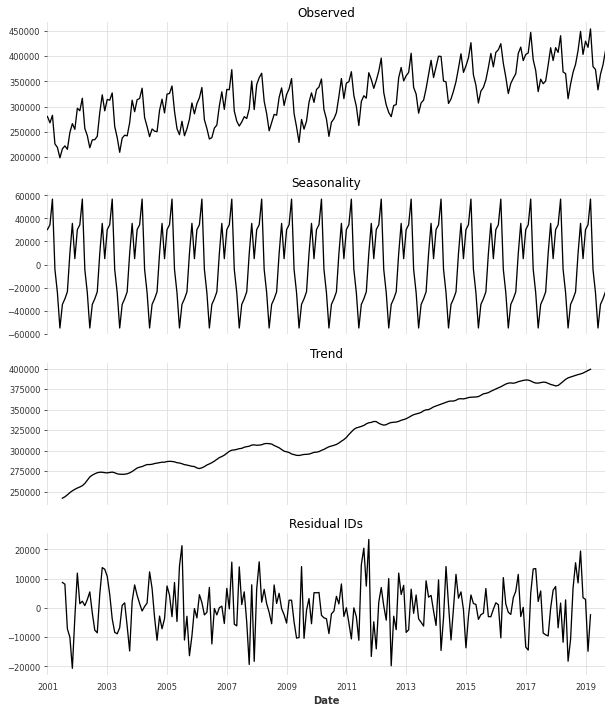

In [361]:
#TotalAucklandOccupancy random forest w/ cond deseasonalize and detrend
y = accomodations['TotalAucklandOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

In [198]:
#Code from machinelearningmastery, Jason Brownlee
# transform a time series dataset into a supervised learning dataset
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols = list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
	# put it all together
	agg = pd.concat(cols, axis=1)
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg.values
 
# split a univariate dataset into train/test sets
def train_test_split(data, n_test):
	return data[:-n_test, :], data[-n_test:, :]
 
# fit an random forest model and make a one step prediction
def random_forest_forecast(train, testX):
	# transform list into array
	train = np.asarray(train)
	# split into input and output columns
	trainX, trainy = train[:, :-1], train[:, -1]
	# fit model
	model = RandomForestRegressor(n_estimators=1000)
	model.fit(trainX, trainy)
	# make a one-step prediction
	yhat = model.predict([testX])
	return yhat[0]
 
# walk-forward validation for univariate data
def walk_forward_validation(data, n_test):
	predictions = list()
	# split dataset
	train, test = train_test_split(data, n_test)
	# seed history with training dataset
	history = [x for x in train]
	# step over each time-step in the test set
	for i in range(len(test)):
		# split test row into input and output columns
		testX, testy = test[i, :-1], test[i, -1]
		# fit model on history and make a prediction
		yhat = random_forest_forecast(history, testX)
		# store forecast in list of predictions
		predictions.append(yhat)
		# add actual observation to history for the next loop
		history.append(test[i])
		# summarize progress
		#print('>expected=%.1f, predicted=%.1f' % (testy, yhat))
	# estimate prediction error
	error = mean_absolute_error(test[:, -1], predictions)
	return error, test[:, -1], predictions

In [381]:
def multistep_forecast(steps, y_list):
    y_pred = y_list.copy()
    
    for s in range(steps):
        train = series_to_supervised(y_pred, n_in=steps)
            # split into input and output columns
        trainX, trainy = train[:, :-1], train[:, -1]
            # fit model
        model = RandomForestRegressor(n_estimators=1000)
        model.fit(trainX, trainy)
        row = y_pred[-steps:]
        yhat = model.predict(np.asarray([row]))
        y_pred.append(yhat[0])
    return y_pred

In [376]:
# Convert data to a list
y_list = list(y)
len(y_list)

225

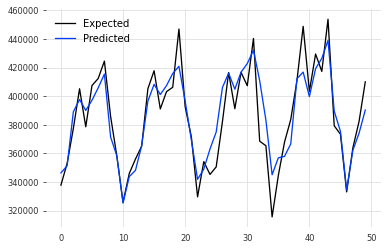

In [271]:
# transform the time series data into supervised learning
data = series_to_supervised(y_list, n_in=50)
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=50)
#print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

In [382]:
# transform the time series data into supervised learning
n = 50
y_pred = multistep_forecast(n, y_list)

In [383]:
len(y_pred)

275

In [384]:
pred_index = range(len(y_pred) - n, len(y_pred))

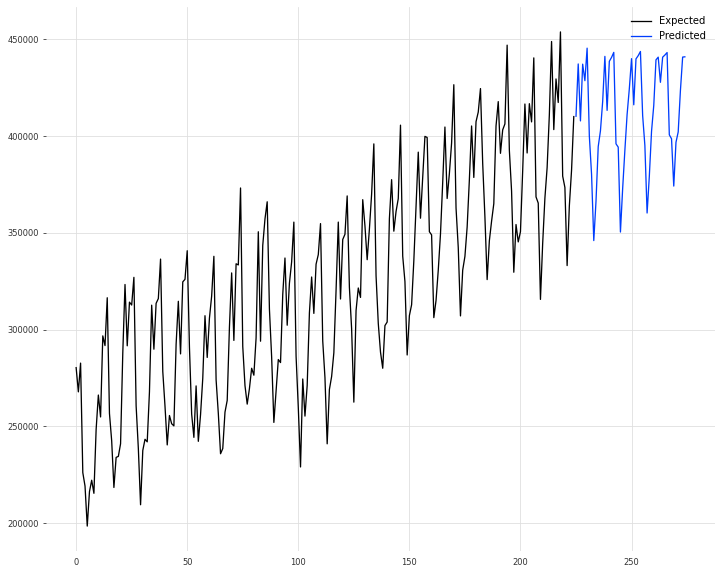

In [386]:
plt.figure(figsize = (12,10))
plt.plot(y_list, label='Expected')
(line1,) = plt.plot(pred_index, y_pred[-n:], label='Predicted')
plt.legend()
plt.show()

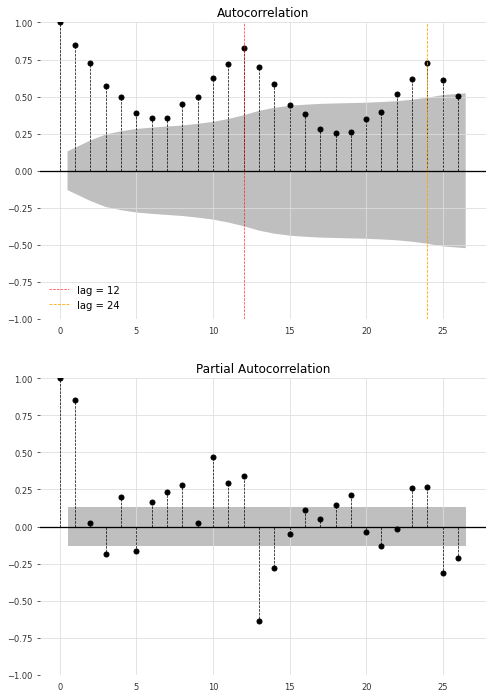

In [307]:
y = accomodations['TotalAucklandOccupancy']
fig, ax = plt.subplots(2, figsize=(8,12))

# plot the ACF
plot_acf(y, ax=ax[0], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

# place marker lines on lags 12 and 24 to highlight the seasonality
ax[0].axvline(12, color='red', ls='--', alpha=0.8, lw=0.7, label='lag = 12')
ax[0].axvline(24, color='orange', ls='--', alpha=1, lw=0.8, label='lag = 24')
ax[0].legend()

# plot the PACF
plot_pacf(y, ax=ax[1], vlines_kwargs={'ls':'--', 'linewidth': 0.7}, lags=26)

plt.show()

In [295]:
auto_arima(y, m=12, method = 'cg', information_criterion = 'bic', error_action = 'ignore').summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  225
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood               -2571.537
Date:                             Fri, 29 Jul 2022   AIC                           5153.074
Time:                                     00:24:47   BIC                           5170.132
Sample:                                          0   HQIC                          5159.959
                                             - 225                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8022      1.341     -0.598      0.550      -3.431       1.827
ma.L1          0.7935      1.323      0.600      0.549      -1.799       3.386
ma.L2          0.0204      0.234      0.087      0.930      -0.437       0.478
ar.S.L12       0.8885      0.019     46.493      0.000       0.851       0.926
sigma2      8.568e+08   4.07e-10    2.1e+18      0.000    8.57e+08    8.57e+08
===================================================================================
Ljung-Box (L1) (Q):                  10.65   Jarque-Bera (JB):             20875.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.24   Skew:                            -4.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        49.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.37e+36. Standard errors may be unstable.
"""

In [296]:
model = sarimax.SARIMAX(y, order=(1,1,2), seasonal_order=(1,0,0,12))
model_fit = model.fit()

forecast = model_fit.forecast(24)
pred = model_fit.predict()[12:]

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:              TotalAucklandOccupancy   No. Observations:                  225
Model:             SARIMAX(1, 1, 2)x(1, 0, [], 12)   Log Likelihood               -2557.490
Date:                             Fri, 29 Jul 2022   AIC                           5124.979
Time:                                     00:25:16   BIC                           5142.038
Sample:                                 01-01-2001   HQIC                          5131.865
                                      - 09-01-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7252      1.257     -0.577      0.564      -3.189       1.738
ma.L1          0.5386      1.279      0.421      0.674      -1.967       3.045
ma.L2         -0.0930      0.376     -0.247      0.805      -0.829       0.643
ar.S.L12       0.6541      0.030     22.083      0.000       0.596       0.712
sigma2      8.568e+08    6.8e-10   1.26e+18      0.000    8.57e+08    8.57e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.90   Jarque-Bera (JB):              1414.89
Prob(Q):                              0.34   Prob(JB):                         0.00
Heteroskedasticity (H):               0.42   Skew:                            -1.77
Prob(H) (two-sided):                  0.00   Kurtosis:                        14.79
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.15e+35. Standard errors may be unstable.
"""

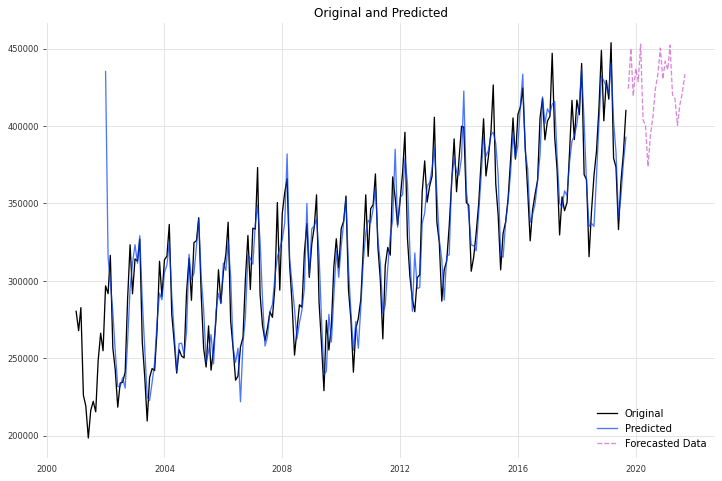

In [297]:
plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(pred, alpha=0.7, label='Predicted')
plt.plot(forecast, label='Forecasted Data', alpha=0.5, ls='--')

plt.legend()
plt.show()
# plt.plot(forecast)

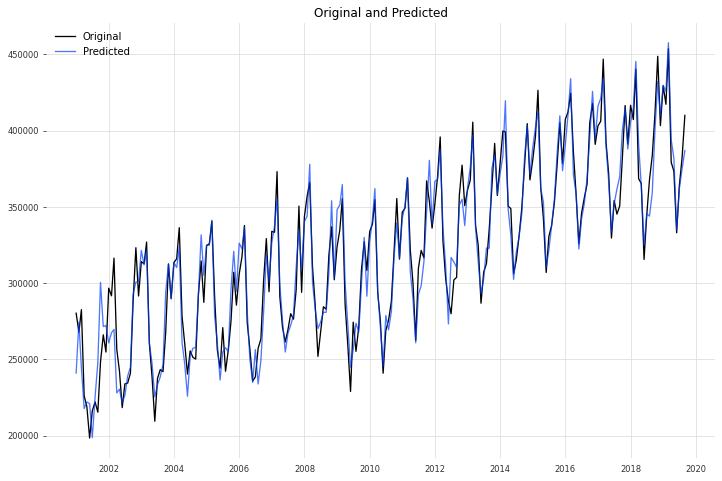

In [308]:
ETS = ETSModel(y, error = 'add', trend = 'mul', seasonal = 'add', seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [309]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                   ETS Results                                    
==================================================================================
Dep. Variable:     TotalAucklandOccupancy   No. Observations:                  225
Model:                           ETS(AMA)   Log Likelihood               -2454.897
Date:                    Fri, 29 Jul 2022   AIC                           4945.795
Time:                            00:27:59   BIC                           5007.285
Sample:                        01-01-2001   HQIC                          4970.612
                             - 09-01-2019   Scale                    175549828.999
Covariance Type:                   approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.2216      0.025      8.806      0.000       0.172       0.271
smoothing_trend      2.216e-05        nan        nan        nan         nan         nan
smoothing_seasonal      0.5645      0.059      9.618      0.000       0.449       0.679
initial_level        2.406e+05   6999.232     34.371      0.000    2.27e+05    2.54e+05
initial_trend           1.0021        nan        nan        nan         nan         nan
initial_seasonal.0   3.029e+04   9997.247      3.030      0.002    1.07e+04    4.99e+04
initial_seasonal.1   2.883e+04   1.05e+04      2.746      0.006    8253.271    4.94e+04
initial_seasonal.2   4.674e+04   8734.311      5.352      0.000    2.96e+04    6.39e+04
initial_seasonal.3  -1.244e+04      1e+04     -1.243      0.214   -3.21e+04    7183.412
initial_seasonal.4  -3.535e+04   1.05e+04     -3.361      0.001    -5.6e+04   -1.47e+04
initial_seasonal.5  -5.739e+04   1.03e+04     -5.555      0.000   -7.76e+04   -3.71e+04
initial_seasonal.6  -3.961e+04   1.03e+04     -3.836      0.000   -5.98e+04   -1.94e+04
initial_seasonal.7  -3.869e+04   1.05e+04     -3.681      0.000   -5.93e+04   -1.81e+04
initial_seasonal.8  -4.056e+04   1.02e+04     -3.980      0.000   -6.05e+04   -2.06e+04
initial_seasonal.9  -4871.1354   8831.924     -0.552      0.581   -2.22e+04    1.24e+04
initial_seasonal.10  2.409e+04   1.05e+04      2.301      0.021    3573.726    4.46e+04
initial_seasonal.11          0   9769.536          0      1.000   -1.91e+04    1.91e+04
===================================================================================
Ljung-Box (Q):                       53.61   Jarque-Bera (JB):                19.05
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.39   Skew:                             0.06
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 6.18e+18. Standard errors may be unstable.
"""

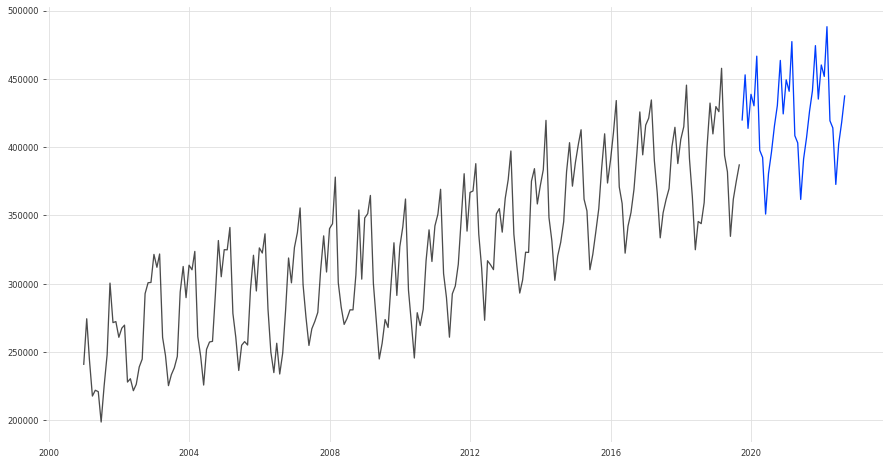

In [310]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

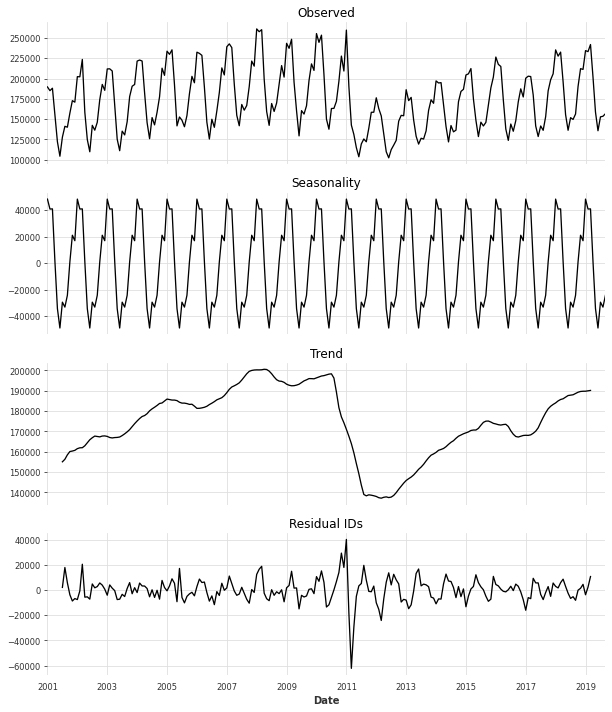

In [107]:
#TotalCanterbury ETS
y = accomodations['TotalCanterburyOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

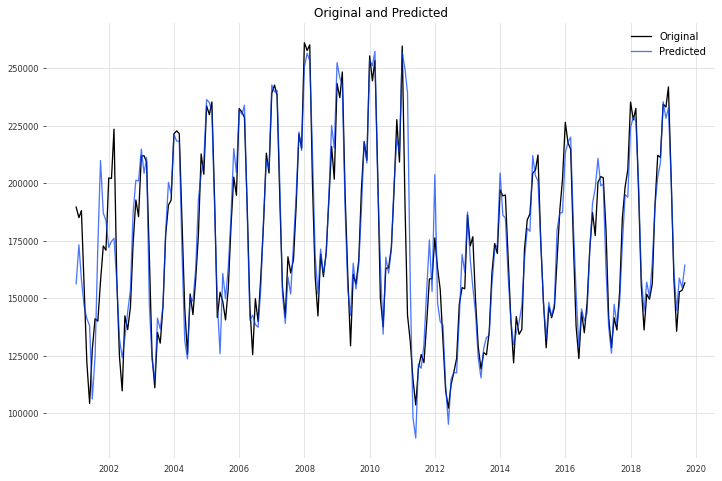

In [108]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [109]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ETS Results                                     
====================================================================================
Dep. Variable:     TotalCanterburyOccupancy   No. Observations:                  225
Model:                             ETS(AAA)   Log Likelihood               -2455.519
Date:                      Thu, 28 Jul 2022   AIC                           4947.038
Time:                              22:39:20   BIC                           5008.528
Sample:                          01-01-2001   HQIC                          4971.855
                               - 09-01-2019   Scale                    176522368.069
Covariance Type:                     approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3428      0.059      5.815      0.000       0.227       0.458
smoothing_trend         0.0016        nan        nan        nan         nan         nan
smoothing_seasonal      0.6119      0.086      7.115      0.000       0.443       0.781
initial_level        1.555e+05   8068.448     19.271      0.000     1.4e+05    1.71e+05
initial_trend         803.6674        nan        nan        nan         nan         nan
initial_seasonal.0   2.837e+04   1.21e+04      2.335      0.020    4559.899    5.22e+04
initial_seasonal.1    2.75e+04   1.13e+04      2.428      0.015    5303.615    4.97e+04
initial_seasonal.2   3.312e+04   1.58e+04      2.091      0.037    2069.346    6.42e+04
initial_seasonal.3  -1.452e+04   1.17e+04     -1.239      0.215   -3.75e+04    8445.973
initial_seasonal.4  -5.594e+04   1.08e+04     -5.173      0.000   -7.71e+04   -3.47e+04
initial_seasonal.5  -6.602e+04    1.1e+04     -6.018      0.000   -8.75e+04   -4.45e+04
initial_seasonal.6  -4.489e+04   1.41e+04     -3.183      0.001   -7.25e+04   -1.73e+04
initial_seasonal.7  -4.739e+04   1.08e+04     -4.406      0.000   -6.85e+04   -2.63e+04
initial_seasonal.8  -3.824e+04   1.15e+04     -3.323      0.001   -6.08e+04   -1.57e+04
initial_seasonal.9   -1.53e+04   1.67e+04     -0.914      0.361   -4.81e+04    1.75e+04
initial_seasonal.10  4656.0625   1.21e+04      0.386      0.699    -1.9e+04    2.83e+04
initial_seasonal.11          0    1.4e+04          0      1.000   -2.74e+04    2.74e+04
===================================================================================
Ljung-Box (Q):                       75.93   Jarque-Bera (JB):              1986.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+17. Standard errors may be unstable.
"""

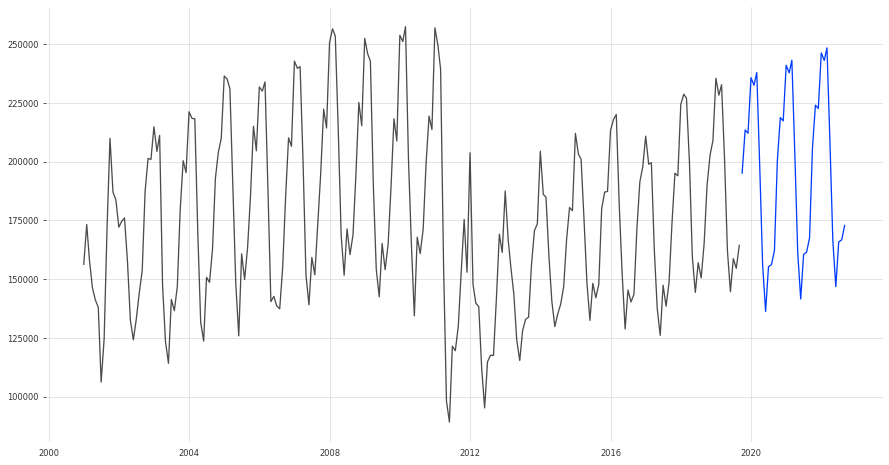

In [110]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

In [ ]:
#TotalWelington Prophet


In [ ]:
#TotalQueenstown AdaBoost

In [ ]:
#TotalTotalnew Zealand KNN 

In [ ]:
#Motels Auckland ETS
y = accomodations['MotelsAucklandOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

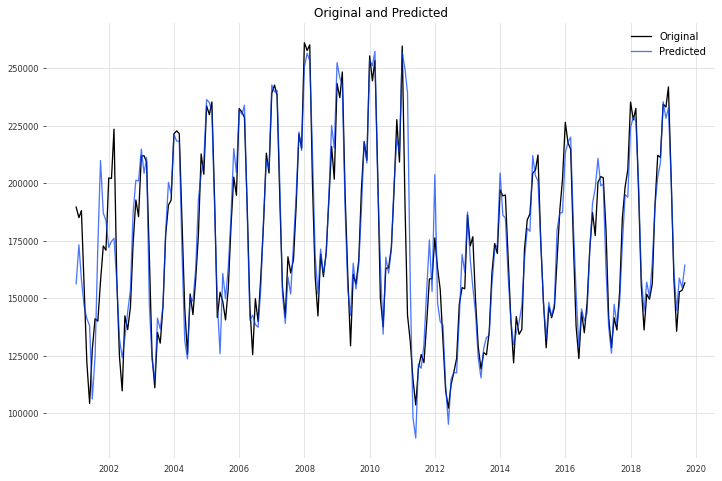

In [112]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'add', seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [113]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ETS Results                                     
====================================================================================
Dep. Variable:     TotalCanterburyOccupancy   No. Observations:                  225
Model:                             ETS(AAA)   Log Likelihood               -2455.519
Date:                      Thu, 28 Jul 2022   AIC                           4947.038
Time:                              22:39:31   BIC                           5008.528
Sample:                          01-01-2001   HQIC                          4971.855
                               - 09-01-2019   Scale                    176522368.069
Covariance Type:                     approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.3428      0.059      5.815      0.000       0.227       0.458
smoothing_trend         0.0016        nan        nan        nan         nan         nan
smoothing_seasonal      0.6119      0.086      7.115      0.000       0.443       0.781
initial_level        1.555e+05   8068.448     19.271      0.000     1.4e+05    1.71e+05
initial_trend         803.6674        nan        nan        nan         nan         nan
initial_seasonal.0   2.837e+04   1.21e+04      2.335      0.020    4559.899    5.22e+04
initial_seasonal.1    2.75e+04   1.13e+04      2.428      0.015    5303.615    4.97e+04
initial_seasonal.2   3.312e+04   1.58e+04      2.091      0.037    2069.346    6.42e+04
initial_seasonal.3  -1.452e+04   1.17e+04     -1.239      0.215   -3.75e+04    8445.973
initial_seasonal.4  -5.594e+04   1.08e+04     -5.173      0.000   -7.71e+04   -3.47e+04
initial_seasonal.5  -6.602e+04    1.1e+04     -6.018      0.000   -8.75e+04   -4.45e+04
initial_seasonal.6  -4.489e+04   1.41e+04     -3.183      0.001   -7.25e+04   -1.73e+04
initial_seasonal.7  -4.739e+04   1.08e+04     -4.406      0.000   -6.85e+04   -2.63e+04
initial_seasonal.8  -3.824e+04   1.15e+04     -3.323      0.001   -6.08e+04   -1.57e+04
initial_seasonal.9   -1.53e+04   1.67e+04     -0.914      0.361   -4.81e+04    1.75e+04
initial_seasonal.10  4656.0625   1.21e+04      0.386      0.699    -1.9e+04    2.83e+04
initial_seasonal.11          0    1.4e+04          0      1.000   -2.74e+04    2.74e+04
===================================================================================
Ljung-Box (Q):                       75.93   Jarque-Bera (JB):              1986.15
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.23   Skew:                            -1.93
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
[2] Covariance matrix is singular or near-singular, with condition number 2.38e+17. Standard errors may be unstable.
"""

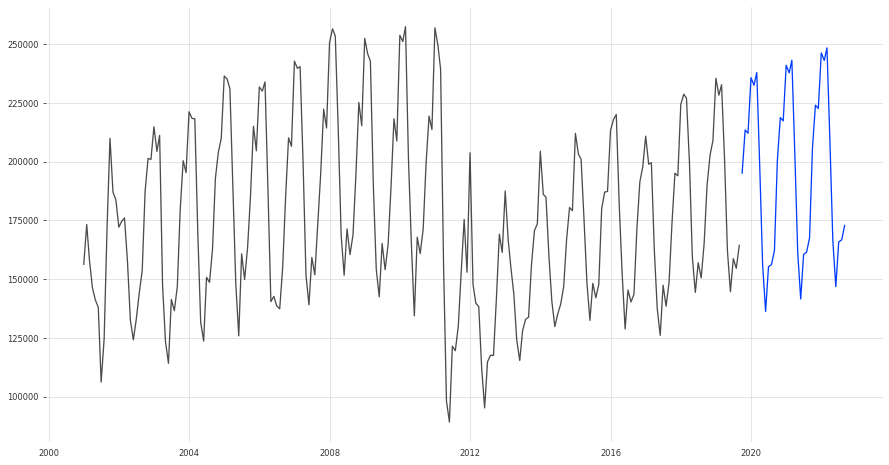

In [114]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)

In [ ]:
#Motels Canterbury Adaboost

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

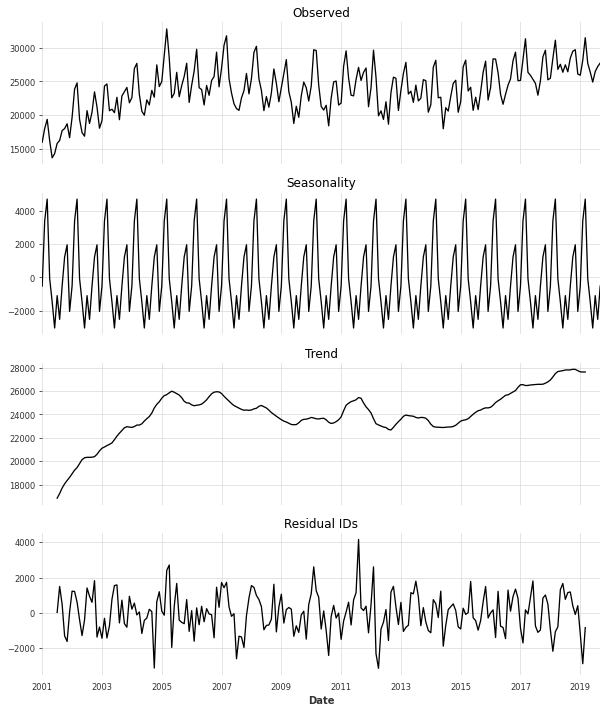

In [387]:
#Motels Wellington Decision Tree
y = accomodations['MotelsWellingtonOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

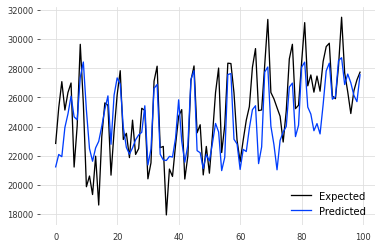

In [353]:
# Convert data to a list
y_list = list(y)
# transform the time series data into supervised learning
data = series_to_supervised(y_list, n_in=100)
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=100)
#print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

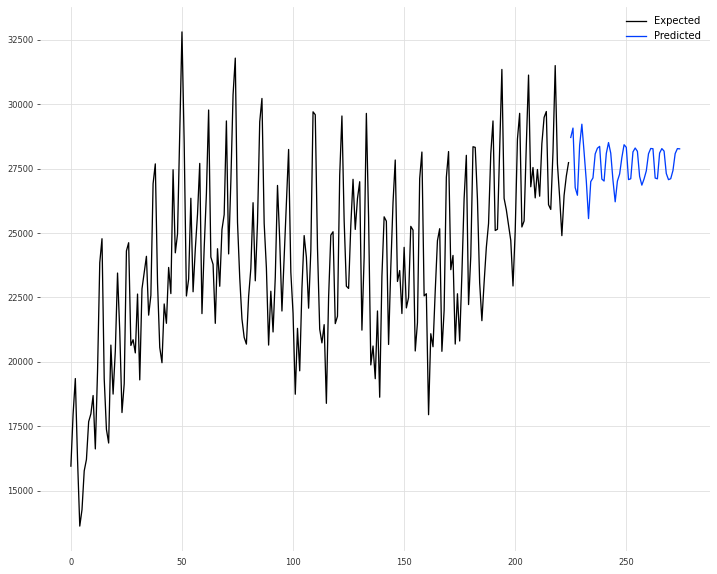

In [391]:
# choose how many steps forward
n = 50
#run func
y_pred = multistep_forecast(n, y_list)
#find length 
pred_index = range(len(y_pred) - n, len(y_pred))
#plot
plt.figure(figsize = (12,10))
plt.plot(y_list, label='Expected')
(line1,) = plt.plot(pred_index, y_pred[-n:], label='Predicted')
plt.legend()
plt.show()

In [ ]:
#Motels Queenstown BATS

In [ ]:
#Motels TNZ LightGBM

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

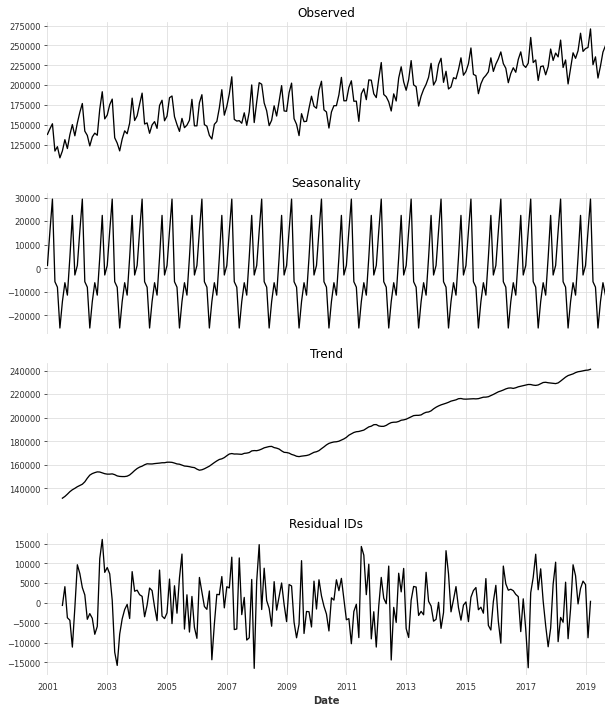

In [392]:
#Hotels Auckland Random Forest
y = accomodations['HotelsAucklandOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

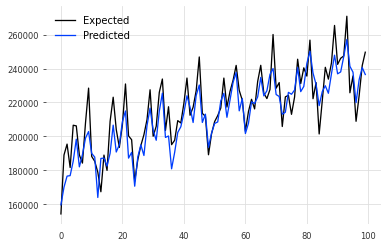

In [393]:
# Convert data to a list
y_list = list(y)
# transform the time series data into supervised learning
data = series_to_supervised(y_list, n_in=100)
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=100)
#print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

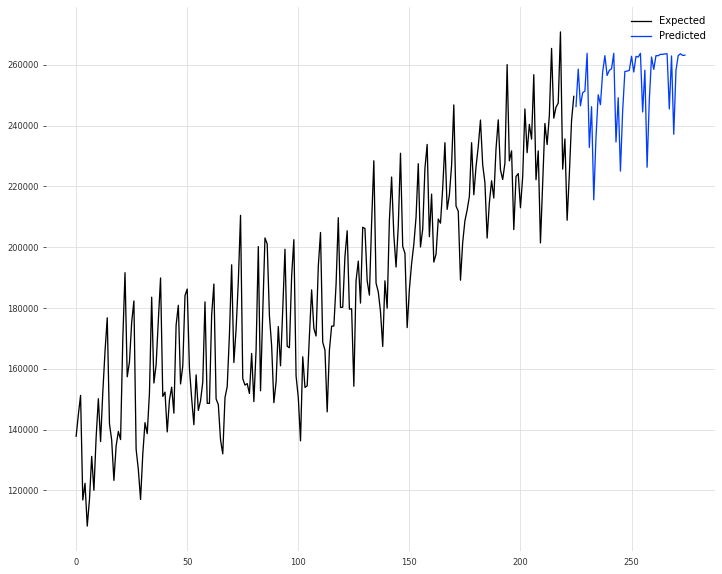

In [394]:
# transform the time series data into supervised learning
n = 50
y_pred = multistep_forecast(n, y_list)
pred_index = range(len(y_pred) - n, len(y_pred))
plt.figure(figsize = (12,10))
plt.plot(y_list, label='Expected')
(line1,) = plt.plot(pred_index, y_pred[-n:], label='Predicted')
plt.legend()
plt.show()

In [ ]:
#Hotels Canterbury Exp Smooth

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

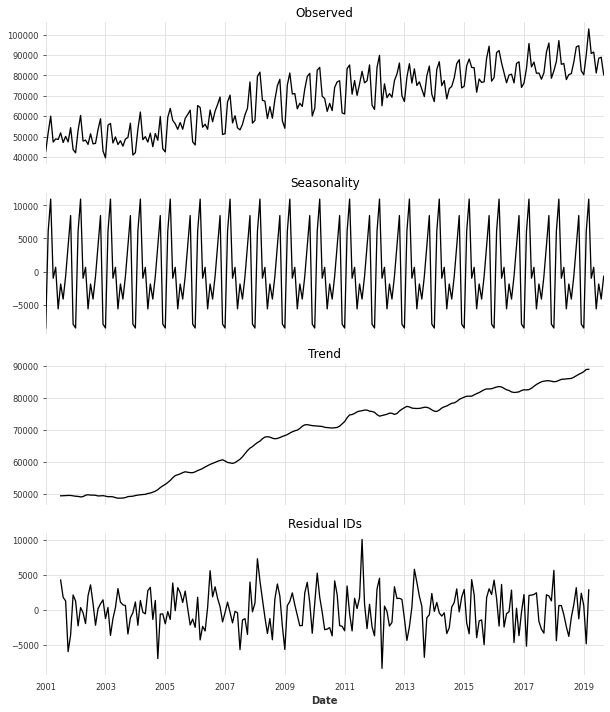

In [395]:
#hotels Wellington Random Forest
y = accomodations['HotelsWellingtonOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

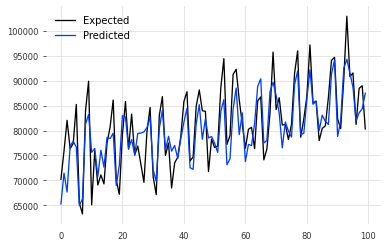

In [396]:
# Convert data to a list
y_list = list(y)
# transform the time series data into supervised learning
data = series_to_supervised(y_list, n_in=100)
# evaluate
mae, y, yhat = walk_forward_validation(data, n_test=100)
#print('MAE: %.3f' % mae)
# plot expected vs predicted
plt.plot(y, label='Expected')
plt.plot(yhat, label='Predicted')
plt.legend()
plt.show()

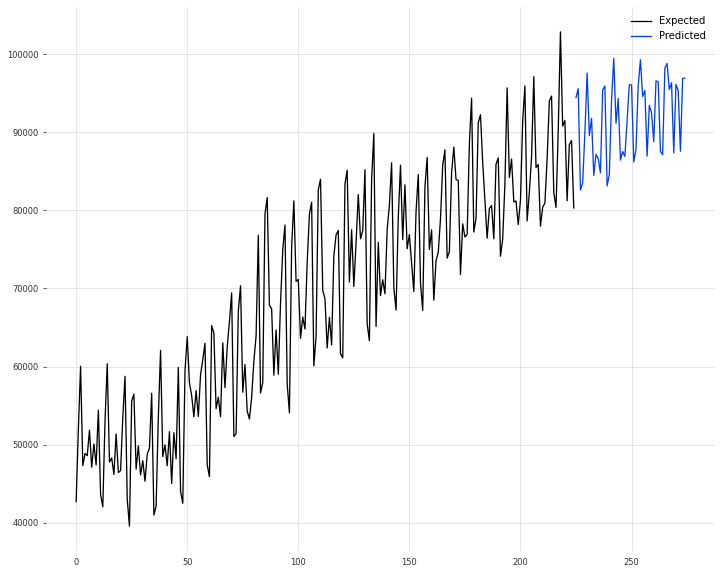

In [397]:
# transform the time series data into supervised learning
n = 50
y_pred = multistep_forecast(n, y_list)
pred_index = range(len(y_pred) - n, len(y_pred))
plt.figure(figsize = (12,10))
plt.plot(y_list, label='Expected')
(line1,) = plt.plot(pred_index, y_pred[-n:], label='Predicted')
plt.legend()
plt.show()

In [ ]:
#Hotels Queenstown Prophet

<AxesSubplot:title={'center':'Residual IDs'}, xlabel='Date'>

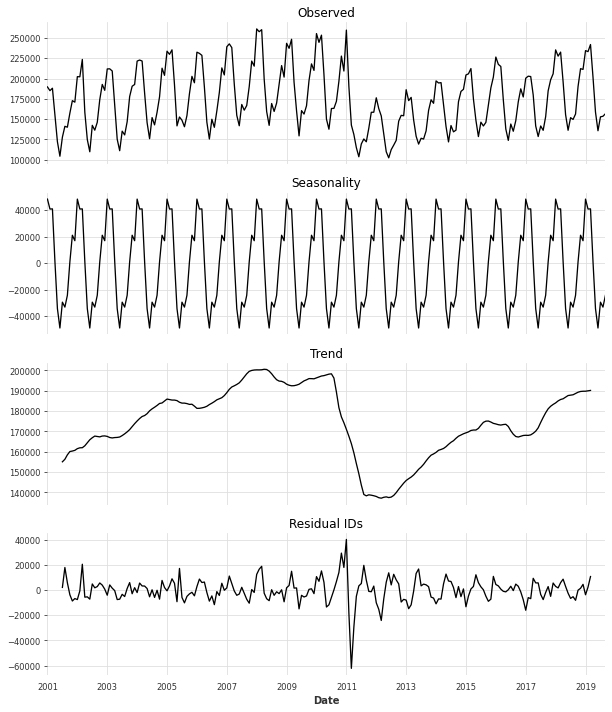

In [115]:
#Hotels TNZ ETS
y = accomodations['TotalCanterburyOccupancy']

res = seasonal_decompose(y, model='add')

# Plot the original data, the trend, the seasonality, and the residuals 
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(10,12), sharex=True);

res.observed.plot(ax=ax1, title='Observed')
res.seasonal.plot(ax=ax2, title='Seasonality')
res.trend.plot(ax=ax3, title='Trend')
res.resid.plot(ax=ax4, title='Residual IDs')

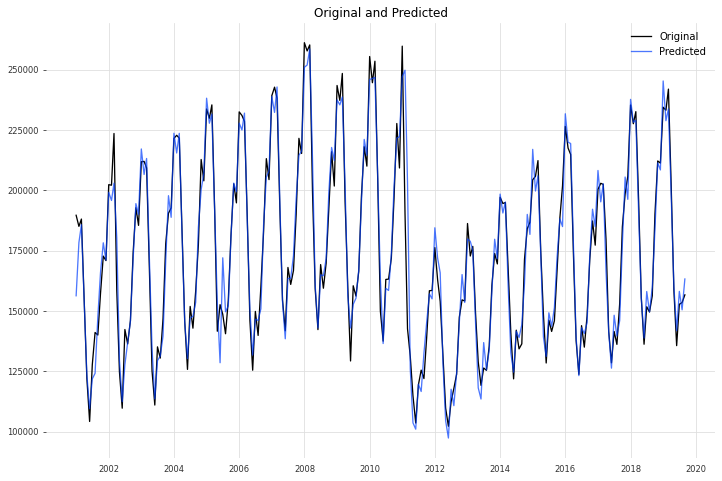

In [119]:
ETS = ETSModel(y, error = 'add', trend = 'add', seasonal = 'mul', seasonal_periods = 12)
ETS_fit = ETS.fit()

plt.figure(figsize=(12,8))

plt.title('Original and Predicted')
plt.plot(y, label='Original')
plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')

plt.legend()

plt.show()

In [120]:
ETS_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    ETS Results                                     
====================================================================================
Dep. Variable:     TotalCanterburyOccupancy   No. Observations:                  225
Model:                             ETS(AAM)   Log Likelihood               -2368.873
Date:                      Thu, 28 Jul 2022   AIC                           4773.746
Time:                              22:41:04   BIC                           4835.236
Sample:                          01-01-2001   HQIC                          4798.563
                               - 09-01-2019   Scale                     81716829.363
Covariance Type:                     approx                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.8112      0.076     10.636      0.000       0.662       0.961
smoothing_trend         0.0018        nan        nan        nan         nan         nan
smoothing_seasonal      0.0118        nan        nan        nan         nan         nan
initial_level        1.555e+05   1.45e+04     10.752      0.000    1.27e+05    1.84e+05
initial_trend         803.6672        nan        nan        nan         nan         nan
initial_seasonal.0      0.8638      0.081     10.701      0.000       0.706       1.022
initial_seasonal.1      0.8815      0.082     10.731      0.000       0.720       1.042
initial_seasonal.2      0.7896      0.074     10.671      0.000       0.645       0.935
initial_seasonal.3      0.6758      0.063     10.674      0.000       0.552       0.800
initial_seasonal.4      0.6342      0.060     10.551      0.000       0.516       0.752
initial_seasonal.5      0.6497      0.062     10.503      0.000       0.528       0.771
initial_seasonal.6      0.5636      0.054     10.477      0.000       0.458       0.669
initial_seasonal.7      0.6327      0.060     10.552      0.000       0.515       0.750
initial_seasonal.8      0.7967      0.074     10.722      0.000       0.651       0.942
initial_seasonal.9      0.9738      0.090     10.815      0.000       0.797       1.150
initial_seasonal.10     0.9680      0.091     10.668      0.000       0.790       1.146
initial_seasonal.11     1.0000      0.094     10.673      0.000       0.816       1.184
===================================================================================
Ljung-Box (Q):                       24.09   Jarque-Bera (JB):              2574.99
Prob(Q):                              0.46   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                            -2.22
Prob(H) (two-sided):                  0.00   Kurtosis:                        18.97
===================================================================================

Warnings:
[1] Covariance matrix calculated using numerical (complex-step) differentiation.
"""

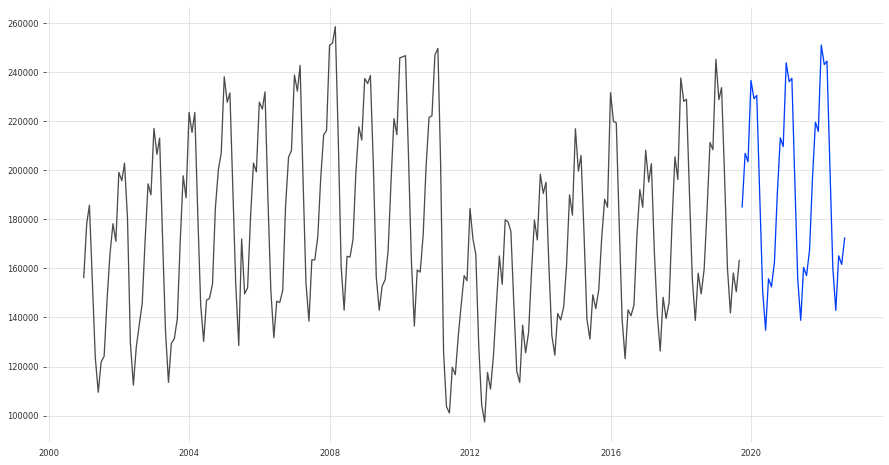

In [121]:
y_fore = ETS_fit.forecast(36)
plt.figure(figsize=(15,8))

plt.plot(ETS_fit.fittedvalues, alpha=0.7, label='Predicted')
(line1,) = plt.plot(y_fore)